In [1]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mamba_ssm import Mamba

In [36]:
!nvidia-smi

Wed Feb 21 16:05:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |   2015MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torch.nn.utils.rnn import pad_sequence

In [16]:
data_dir = "../data/data_preprocessed/crema_d/preprocessed/" 
data_x = np.load(f"{data_dir}crema_d.trill_embedding.train.npy", allow_pickle=True)
data_x.shape

(5144, 2048)

In [17]:
x_train = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_train = pad_sequence(x_train, batch_first=True)
x_train.shape

torch.Size([5144, 2048])

In [18]:
data_x = np.load(f"{data_dir}crema_d.trill_embedding.test.npy", allow_pickle=True)
x_test = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_test = pad_sequence(x_test, batch_first=True)
x_test.shape

torch.Size([1556, 2048])

In [19]:
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)
print(classnames)

['NEU' 'HAP' 'SAD' 'ANG' 'FEA' 'DIS']


In [20]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [21]:
labels = ['ANG', 'NEU', 'SAD']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

torch.Size([2508, 2048])
torch.Size([759, 2048])


In [22]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = x_train[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = x_test[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [24]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [25]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [26]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [27]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [28]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.019801980198019802/10 [00:00<04:27, 26.82s/it]

Train Epoch: 1 [0/2508 (0%)]	Loss: 1.103801
Mem before-during-after: 528384 98276352 20809216


  4%|███████▎                                                                                                                                                                       | 0.41584158415841604/10 [00:07<02:39, 16.63s/it]

Train Epoch: 1 [1280/2508 (51%)]	Loss: 1.050875
Mem before-during-after: 20809216 108751360 20809216


 10%|█████████████████▊                                                                                                                                                              | 1.0099009900990106/10 [00:16<02:24, 16.10s/it]


Test Epoch: 1	Accuracy: 221/736 (29%)

Train Epoch: 2 [0/2508 (0%)]	Loss: 1.108380
Mem before-during-after: 20805120 108751360 20809216


 14%|████████████████████████▉                                                                                                                                                       | 1.4158415841584169/10 [00:23<02:19, 16.27s/it]

Train Epoch: 2 [1280/2508 (51%)]	Loss: 1.093361
Mem before-during-after: 20809216 108751360 20809216


 20%|███████████████████████████████████▎                                                                                                                                            | 2.0099009900990112/10 [00:33<02:07, 15.92s/it]


Test Epoch: 2	Accuracy: 261/736 (34%)

Train Epoch: 3 [0/2508 (0%)]	Loss: 1.079923
Mem before-during-after: 20805120 108751360 20809216


 24%|██████████████████████████████████████████▌                                                                                                                                     | 2.4158415841584175/10 [00:39<02:04, 16.44s/it]

Train Epoch: 3 [1280/2508 (51%)]	Loss: 1.049655
Mem before-during-after: 20809216 108751360 20809216


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 3.009900990099012/10 [00:49<01:53, 16.23s/it]


Test Epoch: 3	Accuracy: 462/736 (61%)

Train Epoch: 4 [0/2508 (0%)]	Loss: 0.955922
Mem before-during-after: 20805120 108751360 20809216


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 3.4158415841584184/10 [00:56<01:50, 16.74s/it]

Train Epoch: 4 [1280/2508 (51%)]	Loss: 1.105965
Mem before-during-after: 20809216 108751360 20809216


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.009900990099013/10 [01:06<01:36, 16.13s/it]


Test Epoch: 4	Accuracy: 372/736 (49%)

Train Epoch: 5 [0/2508 (0%)]	Loss: 1.113236
Mem before-during-after: 20805120 108751360 20809216


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 4.415841584158419/10 [01:12<01:31, 16.44s/it]

Train Epoch: 5 [1280/2508 (51%)]	Loss: 0.656649
Mem before-during-after: 20809216 108751360 20809216


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 5.0099009900990135/10 [01:22<01:21, 16.38s/it]


Test Epoch: 5	Accuracy: 471/736 (62%)

Train Epoch: 6 [0/2508 (0%)]	Loss: 0.774232
Mem before-during-after: 20805120 108751360 20809216


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5.41584158415842/10 [01:29<01:15, 16.44s/it]

Train Epoch: 6 [1280/2508 (51%)]	Loss: 1.115410
Mem before-during-after: 20809216 108751360 20809216


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6.009900990099014/10 [01:38<01:04, 16.12s/it]


Test Epoch: 6	Accuracy: 318/736 (42%)

Train Epoch: 7 [0/2508 (0%)]	Loss: 1.083469
Mem before-during-after: 20805120 108751360 20809216


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6.415841584158421/10 [01:45<00:59, 16.48s/it]

Train Epoch: 7 [1280/2508 (51%)]	Loss: 0.712610
Mem before-during-after: 20809216 108751360 20809216


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7.009900990099015/10 [01:55<00:47, 15.94s/it]


Test Epoch: 7	Accuracy: 481/736 (63%)

Train Epoch: 8 [0/2508 (0%)]	Loss: 0.732566
Mem before-during-after: 20805120 108751360 20809216


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.4158415841584215/10 [02:01<00:41, 16.12s/it]

Train Epoch: 8 [1280/2508 (51%)]	Loss: 0.900686
Mem before-during-after: 20809216 108751360 20809216


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.009900990099014/10 [02:11<00:31, 15.95s/it]


Test Epoch: 8	Accuracy: 525/736 (69%)

Train Epoch: 9 [0/2508 (0%)]	Loss: 0.775951
Mem before-during-after: 20805120 108751360 20809216


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8.415841584158384/10 [02:18<00:26, 16.50s/it]

Train Epoch: 9 [1280/2508 (51%)]	Loss: 1.098814
Mem before-during-after: 20809216 108751360 20809216


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.009900990098926/10 [02:27<00:15, 16.10s/it]


Test Epoch: 9	Accuracy: 449/736 (59%)

Train Epoch: 10 [0/2508 (0%)]	Loss: 0.851085
Mem before-during-after: 20805120 108751360 20809216


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.415841584158295/10 [02:34<00:09, 16.66s/it]

Train Epoch: 10 [1280/2508 (51%)]	Loss: 0.715603
Mem before-during-after: 20809216 108751360 20809216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999828/10 [02:44<00:00, 16.42s/it]


Test Epoch: 10	Accuracy: 511/736 (67%)



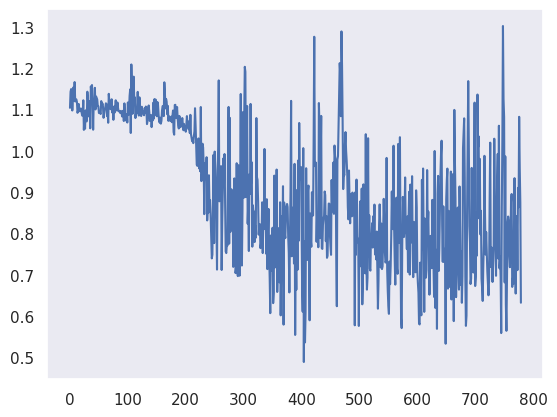

In [29]:
plt.plot(train_losses)

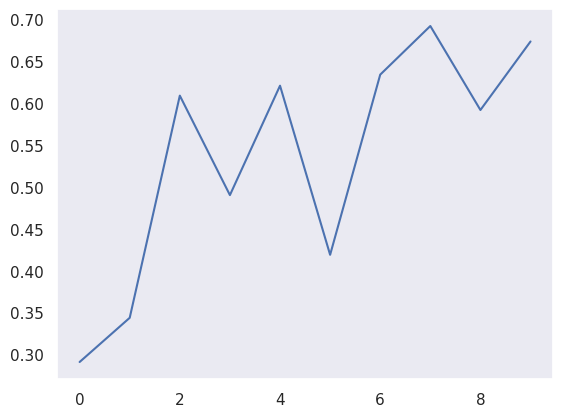

In [30]:
plt.plot(test_accuracy)

In [31]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [32]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 514/736 (0.6984)
{'acc_detail': tensor([0.9308, 0.4864, 0.6445], device='cuda:0'),
 'acc_unweighted': tensor(0.6872, device='cuda:0'),
 'acc_weighted': tensor(0.6984, device='cuda:0'),
 'f1s': tensor(0.6811, device='cuda:0'),
 'f1s_detail': tensor([0.7961, 0.5284, 0.7190], device='cuda:0'),
 'precision_detail': tensor([0.6954, 0.5784, 0.8128], device='cuda:0'),
 'recall_detail': tensor([0.9308, 0.4864, 0.6445], device='cuda:0'),
 'rocauc': tensor([0.9457, 0.7429, 0.8904], device='cuda:0'),
 'uar': tensor(0.6872, device='cuda:0'),
 'wap': tensor(0.7013, device='cuda:0')}


tensor([[242,  18,   0],
        [ 75, 107,  38],
        [ 31,  60, 165]], device='cuda:0')

In [34]:
model_path = '../models_cremad3/cremad_label3_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [35]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:08, 19.39s/it]

Train Epoch: 11 [0/2508 (0%)]	Loss: 0.832731
Mem before-during-after: 19798528 107744768 20855296


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:07<15:29, 18.76s/it]

Train Epoch: 11 [1280/2508 (51%)]	Loss: 0.583193
Mem before-during-after: 20855296 108797440 20855296


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:18<15:00, 18.38s/it]


Test Epoch: 11	Accuracy: 517/736 (68%)

saved model: ../models_cremad3/cremad_label3_m12new_best_11epoch.pt
Train Epoch: 12 [0/2508 (0%)]	Loss: 0.783334
Mem before-during-after: 20851200 108797440 20855296


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:26<15:12, 18.79s/it]

Train Epoch: 12 [1280/2508 (51%)]	Loss: 0.795652
Mem before-during-after: 20855296 108797440 20855296


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:37<14:46, 18.48s/it]


Test Epoch: 12	Accuracy: 522/736 (69%)

saved model: ../models_cremad3/cremad_label3_m12new_best_12epoch.pt
Train Epoch: 13 [0/2508 (0%)]	Loss: 0.668745
Mem before-during-after: 20851200 108797440 20855296


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:45<15:02, 18.97s/it]

Train Epoch: 13 [1280/2508 (51%)]	Loss: 0.583069
Mem before-during-after: 20855296 108797440 20855296


  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [00:56<14:25, 18.41s/it]


Test Epoch: 13	Accuracy: 522/736 (69%)

Train Epoch: 14 [0/2508 (0%)]	Loss: 0.762520
Mem before-during-after: 20851200 108797440 20855296


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:03<14:39, 18.87s/it]

Train Epoch: 14 [1280/2508 (51%)]	Loss: 0.876204
Mem before-during-after: 20855296 108797440 20855296


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:14<14:05, 18.39s/it]


Test Epoch: 14	Accuracy: 507/736 (67%)

Train Epoch: 15 [0/2508 (0%)]	Loss: 0.636749
Mem before-during-after: 20851200 108797440 20855296


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:22<14:19, 18.85s/it]

Train Epoch: 15 [1280/2508 (51%)]	Loss: 0.799123
Mem before-during-after: 20855296 108797440 20855296


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:33<13:42, 18.29s/it]


Test Epoch: 15	Accuracy: 491/736 (65%)

Train Epoch: 16 [0/2508 (0%)]	Loss: 0.773857
Mem before-during-after: 20851200 108797440 20855296


 11%|███████████████████▎                                                                                                                                                              | 5.41584158415842/50 [01:40<13:37, 18.34s/it]

Train Epoch: 16 [1280/2508 (51%)]	Loss: 1.129833
Mem before-during-after: 20855296 108797440 20855296


 12%|█████████████████████▎                                                                                                                                                           | 6.009900990099014/50 [01:51<13:14, 18.06s/it]


Test Epoch: 16	Accuracy: 460/736 (61%)

Train Epoch: 17 [0/2508 (0%)]	Loss: 0.610411
Mem before-during-after: 20851200 108797440 20855296


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [01:59<13:26, 18.51s/it]

Train Epoch: 17 [1280/2508 (51%)]	Loss: 0.833390
Mem before-during-after: 20855296 108797440 20855296


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:10<13:10, 18.40s/it]


Test Epoch: 17	Accuracy: 510/736 (67%)

Train Epoch: 18 [0/2508 (0%)]	Loss: 0.642170
Mem before-during-after: 20851200 108797440 20855296


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:17<13:29, 19.02s/it]

Train Epoch: 18 [1280/2508 (51%)]	Loss: 0.761274
Mem before-during-after: 20855296 108797440 20855296


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [02:28<12:43, 18.17s/it]


Test Epoch: 18	Accuracy: 491/736 (65%)

Train Epoch: 19 [0/2508 (0%)]	Loss: 1.003650
Mem before-during-after: 20851200 108797440 20855296


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:36<12:59, 18.75s/it]

Train Epoch: 19 [1280/2508 (51%)]	Loss: 0.916530
Mem before-during-after: 20855296 108797440 20855296


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:47<12:31, 18.32s/it]


Test Epoch: 19	Accuracy: 514/736 (68%)

Train Epoch: 20 [0/2508 (0%)]	Loss: 0.654644
Mem before-during-after: 20851200 108797440 20855296


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [02:55<12:21, 18.28s/it]

Train Epoch: 20 [1280/2508 (51%)]	Loss: 0.796694
Mem before-during-after: 20855296 108797440 20855296


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:06<11:56, 17.92s/it]


Test Epoch: 20	Accuracy: 402/736 (53%)

Train Epoch: 21 [0/2508 (0%)]	Loss: 0.879086
Mem before-during-after: 20851200 108797440 20855296


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:13<12:30, 18.97s/it]

Train Epoch: 21 [1280/2508 (51%)]	Loss: 0.782279
Mem before-during-after: 20855296 108797440 20855296


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:24<12:11, 18.76s/it]


Test Epoch: 21	Accuracy: 487/736 (64%)

Train Epoch: 22 [0/2508 (0%)]	Loss: 0.708266
Mem before-during-after: 20851200 108797440 20855296


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.415841584158118/50 [03:32<12:14, 19.04s/it]

Train Epoch: 22 [1280/2508 (51%)]	Loss: 0.747288
Mem before-during-after: 20855296 108797440 20855296


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:43<11:27, 18.09s/it]


Test Epoch: 22	Accuracy: 518/736 (68%)

Train Epoch: 23 [0/2508 (0%)]	Loss: 0.691820
Mem before-during-after: 20851200 108797440 20855296


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [03:51<11:45, 18.78s/it]

Train Epoch: 23 [1280/2508 (51%)]	Loss: 0.773212
Mem before-during-after: 20855296 108797440 20855296


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.00990099009857/50 [04:02<11:06, 18.02s/it]


Test Epoch: 23	Accuracy: 387/736 (51%)

Train Epoch: 24 [0/2508 (0%)]	Loss: 0.894540
Mem before-during-after: 20851200 108797440 20855296


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:09<11:31, 18.91s/it]

Train Epoch: 24 [1280/2508 (51%)]	Loss: 0.794119
Mem before-during-after: 20855296 108797440 20855296


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:20<11:17, 18.82s/it]


Test Epoch: 24	Accuracy: 508/736 (67%)

Train Epoch: 25 [0/2508 (0%)]	Loss: 0.746269
Mem before-during-after: 20851200 108797440 20855296


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:28<11:21, 19.14s/it]

Train Epoch: 25 [1280/2508 (51%)]	Loss: 0.586990
Mem before-during-after: 20855296 108797440 20855296


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:39<10:57, 18.79s/it]


Test Epoch: 25	Accuracy: 484/736 (64%)

Train Epoch: 26 [0/2508 (0%)]	Loss: 0.661686
Mem before-during-after: 20851200 108797440 20855296


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [04:47<10:51, 18.84s/it]

Train Epoch: 26 [1280/2508 (51%)]	Loss: 0.561061
Mem before-during-after: 20855296 108797440 20855296


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [04:58<10:22, 18.32s/it]


Test Epoch: 26	Accuracy: 486/736 (64%)

Train Epoch: 27 [0/2508 (0%)]	Loss: 0.680844
Mem before-during-after: 20851200 108797440 20855296


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:06<10:43, 19.15s/it]

Train Epoch: 27 [1280/2508 (51%)]	Loss: 0.581544
Mem before-during-after: 20855296 108797440 20855296


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:17<10:18, 18.75s/it]


Test Epoch: 27	Accuracy: 490/736 (65%)

Train Epoch: 28 [0/2508 (0%)]	Loss: 0.773919
Mem before-during-after: 20851200 108797440 20855296


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:25<10:03, 18.52s/it]

Train Epoch: 28 [1280/2508 (51%)]	Loss: 0.684477
Mem before-during-after: 20855296 108797440 20855296


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:36<09:41, 18.17s/it]


Test Epoch: 28	Accuracy: 445/736 (59%)

Train Epoch: 29 [0/2508 (0%)]	Loss: 0.733355
Mem before-during-after: 20851200 108797440 20855296


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [05:43<09:56, 18.89s/it]

Train Epoch: 29 [1280/2508 (51%)]	Loss: 0.852159
Mem before-during-after: 20855296 108797440 20855296


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [05:55<09:50, 19.07s/it]


Test Epoch: 29	Accuracy: 422/736 (56%)

Train Epoch: 30 [0/2508 (0%)]	Loss: 1.351773
Mem before-during-after: 20851200 108797440 20855296


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:02<09:32, 18.72s/it]

Train Epoch: 30 [1280/2508 (51%)]	Loss: 0.588068
Mem before-during-after: 20855296 108797440 20855296


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00990099009795/50 [06:13<08:56, 17.90s/it]


Test Epoch: 30	Accuracy: 485/736 (64%)

Train Epoch: 31 [0/2508 (0%)]	Loss: 0.887058
Mem before-during-after: 20851200 108797440 20855296


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:21<08:59, 18.25s/it]

Train Epoch: 31 [1280/2508 (51%)]	Loss: 1.177021
Mem before-during-after: 20855296 108797440 20855296


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:31<08:40, 17.96s/it]


Test Epoch: 31	Accuracy: 514/736 (68%)

Train Epoch: 32 [0/2508 (0%)]	Loss: 0.771378
Mem before-during-after: 20851200 108797440 20855296


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [06:39<08:44, 18.33s/it]

Train Epoch: 32 [1280/2508 (51%)]	Loss: 1.228065
Mem before-during-after: 20855296 108797440 20855296


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [06:50<08:22, 17.95s/it]


Test Epoch: 32	Accuracy: 494/736 (65%)

Train Epoch: 33 [0/2508 (0%)]	Loss: 0.735050
Mem before-during-after: 20851200 108797440 20855296


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [06:57<08:26, 18.37s/it]

Train Epoch: 33 [1280/2508 (51%)]	Loss: 0.983063
Mem before-during-after: 20855296 108797440 20855296


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:08<08:18, 18.45s/it]


Test Epoch: 33	Accuracy: 453/736 (60%)

Train Epoch: 34 [0/2508 (0%)]	Loss: 1.181239
Mem before-during-after: 20851200 108797440 20855296


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:16<08:24, 18.96s/it]

Train Epoch: 34 [1280/2508 (51%)]	Loss: 0.553761
Mem before-during-after: 20855296 108797440 20855296


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:27<08:05, 18.70s/it]


Test Epoch: 34	Accuracy: 490/736 (65%)

Train Epoch: 35 [0/2508 (0%)]	Loss: 0.732094
Mem before-during-after: 20851200 108797440 20855296


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [07:35<08:04, 18.92s/it]

Train Epoch: 35 [1280/2508 (51%)]	Loss: 1.086162
Mem before-during-after: 20855296 108797440 20855296


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [07:46<07:33, 18.14s/it]


Test Epoch: 35	Accuracy: 532/736 (70%)

saved model: ../models_cremad3/cremad_label3_m12new_best_35epoch.pt
Train Epoch: 36 [0/2508 (0%)]	Loss: 0.656243
Mem before-during-after: 20851200 108797440 20855296


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [07:53<07:32, 18.40s/it]

Train Epoch: 36 [1280/2508 (51%)]	Loss: 0.938398
Mem before-during-after: 20855296 108797440 20855296


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.009900990097417/50 [08:04<07:13, 18.06s/it]


Test Epoch: 36	Accuracy: 484/736 (64%)

Train Epoch: 37 [0/2508 (0%)]	Loss: 0.605116
Mem before-during-after: 20851200 108797440 20855296


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:12<07:23, 18.81s/it]

Train Epoch: 37 [1280/2508 (51%)]	Loss: 0.580581
Mem before-during-after: 20855296 108797440 20855296


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:23<06:57, 18.17s/it]


Test Epoch: 37	Accuracy: 499/736 (66%)

Train Epoch: 38 [0/2508 (0%)]	Loss: 0.891295
Mem before-during-after: 20851200 108797440 20855296


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [08:30<07:15, 19.30s/it]

Train Epoch: 38 [1280/2508 (51%)]	Loss: 0.841971
Mem before-during-after: 20855296 108797440 20855296


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [08:41<06:42, 18.29s/it]


Test Epoch: 38	Accuracy: 525/736 (69%)

Train Epoch: 39 [0/2508 (0%)]	Loss: 0.649933
Mem before-during-after: 20851200 108797440 20855296


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [08:49<06:33, 18.21s/it]

Train Epoch: 39 [1280/2508 (51%)]	Loss: 0.537323
Mem before-during-after: 20855296 108797440 20855296


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.00990099009715/50 [08:59<06:13, 17.81s/it]


Test Epoch: 39	Accuracy: 523/736 (69%)

Train Epoch: 40 [0/2508 (0%)]	Loss: 0.738714
Mem before-during-after: 20851200 108797440 20855296


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:07<06:15, 18.24s/it]

Train Epoch: 40 [1280/2508 (51%)]	Loss: 0.563042
Mem before-during-after: 20855296 108797440 20855296


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:17<05:56, 17.85s/it]


Test Epoch: 40	Accuracy: 417/736 (55%)

Train Epoch: 41 [0/2508 (0%)]	Loss: 1.128240
Mem before-during-after: 20851200 108797440 20855296


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:25<06:01, 18.48s/it]

Train Epoch: 41 [1280/2508 (51%)]	Loss: 0.678123
Mem before-during-after: 20855296 108797440 20855296


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.009900990096973/50 [09:36<05:52, 18.55s/it]


Test Epoch: 41	Accuracy: 506/736 (67%)

Train Epoch: 42 [0/2508 (0%)]	Loss: 0.661813
Mem before-during-after: 20851200 108797440 20855296


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [09:43<05:53, 19.01s/it]

Train Epoch: 42 [1280/2508 (51%)]	Loss: 0.855830
Mem before-during-after: 20855296 108797440 20855296


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [09:55<05:27, 18.20s/it]


Test Epoch: 42	Accuracy: 520/736 (69%)

Train Epoch: 43 [0/2508 (0%)]	Loss: 0.635841
Mem before-during-after: 20851200 108797440 20855296


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:02<05:31, 18.84s/it]

Train Epoch: 43 [1280/2508 (51%)]	Loss: 1.080383
Mem before-during-after: 20855296 108797440 20855296


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00990099009716/50 [10:13<05:04, 17.95s/it]


Test Epoch: 43	Accuracy: 522/736 (69%)

Train Epoch: 44 [0/2508 (0%)]	Loss: 0.695346
Mem before-during-after: 20851200 108797440 20855296


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:21<05:09, 18.65s/it]

Train Epoch: 44 [1280/2508 (51%)]	Loss: 0.549478
Mem before-during-after: 20855296 108797440 20855296


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [10:31<04:52, 18.27s/it]


Test Epoch: 44	Accuracy: 464/736 (61%)

Train Epoch: 45 [0/2508 (0%)]	Loss: 0.706734
Mem before-during-after: 20851200 108797440 20855296


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [10:39<04:51, 18.69s/it]

Train Epoch: 45 [1280/2508 (51%)]	Loss: 0.989222
Mem before-during-after: 20855296 108797440 20855296


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [10:50<04:32, 18.16s/it]


Test Epoch: 45	Accuracy: 500/736 (66%)

Train Epoch: 46 [0/2508 (0%)]	Loss: 0.791415
Mem before-during-after: 20851200 108797440 20855296


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [10:58<04:28, 18.40s/it]

Train Epoch: 46 [1280/2508 (51%)]	Loss: 1.023922
Mem before-during-after: 20855296 108797440 20855296


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00990099009797/50 [11:08<04:18, 18.48s/it]


Test Epoch: 46	Accuracy: 383/736 (50%)

Train Epoch: 47 [0/2508 (0%)]	Loss: 0.908448
Mem before-during-after: 20851200 108797440 20855296


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:16<04:10, 18.47s/it]

Train Epoch: 47 [1280/2508 (51%)]	Loss: 0.711141
Mem before-during-after: 20855296 108797440 20855296


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.00990099009824/50 [11:27<03:58, 18.35s/it]


Test Epoch: 47	Accuracy: 530/736 (70%)

Train Epoch: 48 [0/2508 (0%)]	Loss: 0.490690
Mem before-during-after: 20851200 108797440 20855296


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [11:35<03:57, 18.90s/it]

Train Epoch: 48 [1280/2508 (51%)]	Loss: 0.654215
Mem before-during-after: 20855296 108797440 20855296


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [11:46<03:44, 18.71s/it]


Test Epoch: 48	Accuracy: 532/736 (70%)

Train Epoch: 49 [0/2508 (0%)]	Loss: 0.693253
Mem before-during-after: 20851200 108797440 20855296


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [11:54<03:39, 18.95s/it]

Train Epoch: 49 [1280/2508 (51%)]	Loss: 0.817557
Mem before-during-after: 20855296 108797440 20855296


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [12:05<03:17, 17.94s/it]


Test Epoch: 49	Accuracy: 519/736 (68%)

Train Epoch: 50 [0/2508 (0%)]	Loss: 0.870135
Mem before-during-after: 20851200 108797440 20855296


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:12<03:13, 18.32s/it]

Train Epoch: 50 [1280/2508 (51%)]	Loss: 0.542196
Mem before-during-after: 20855296 108797440 20855296


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [12:23<03:02, 18.22s/it]


Test Epoch: 50	Accuracy: 487/736 (64%)

Train Epoch: 51 [0/2508 (0%)]	Loss: 0.713064
Mem before-during-after: 20851200 108797440 20855296


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [12:31<02:57, 18.52s/it]

Train Epoch: 51 [1280/2508 (51%)]	Loss: 0.981983
Mem before-during-after: 20855296 108797440 20855296


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [12:42<02:42, 18.08s/it]


Test Epoch: 51	Accuracy: 520/736 (69%)

Train Epoch: 52 [0/2508 (0%)]	Loss: 0.620505
Mem before-during-after: 20851200 108797440 20855296


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [12:49<02:40, 18.67s/it]

Train Epoch: 52 [1280/2508 (51%)]	Loss: 0.656505
Mem before-during-after: 20855296 108797440 20855296


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00990099009959/50 [13:00<02:26, 18.32s/it]


Test Epoch: 52	Accuracy: 538/736 (71%)

saved model: ../models_cremad3/cremad_label3_m12new_best_52epoch.pt
Train Epoch: 53 [0/2508 (0%)]	Loss: 0.411114
Mem before-during-after: 20851200 108797440 20855296


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:08<02:35, 20.45s/it]

Train Epoch: 53 [1280/2508 (51%)]	Loss: 0.566776
Mem before-during-after: 20855296 108797440 20855296


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [13:19<02:09, 18.52s/it]


Test Epoch: 53	Accuracy: 506/736 (67%)

Train Epoch: 54 [0/2508 (0%)]	Loss: 0.903012
Mem before-during-after: 20851200 108797440 20855296


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [13:27<02:05, 19.06s/it]

Train Epoch: 54 [1280/2508 (51%)]	Loss: 0.726770
Mem before-during-after: 20855296 108797440 20855296


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [13:38<01:49, 18.29s/it]


Test Epoch: 54	Accuracy: 512/736 (67%)

Train Epoch: 55 [0/2508 (0%)]	Loss: 0.594101
Mem before-during-after: 20851200 108797440 20855296


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.415841584159644/50 [13:46<01:46, 19.04s/it]

Train Epoch: 55 [1280/2508 (51%)]	Loss: 0.916305
Mem before-during-after: 20855296 108797440 20855296


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 45.0099009901004/50 [13:57<01:29, 18.03s/it]


Test Epoch: 55	Accuracy: 532/736 (70%)

Train Epoch: 56 [0/2508 (0%)]	Loss: 0.908237
Mem before-during-after: 20851200 108797440 20855296


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:04<01:24, 18.33s/it]

Train Epoch: 56 [1280/2508 (51%)]	Loss: 0.830296
Mem before-during-after: 20855296 108797440 20855296


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [14:15<01:11, 17.99s/it]


Test Epoch: 56	Accuracy: 527/736 (69%)

Train Epoch: 57 [0/2508 (0%)]	Loss: 0.748840
Mem before-during-after: 20851200 108797440 20855296


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [14:23<01:05, 18.35s/it]

Train Epoch: 57 [1280/2508 (51%)]	Loss: 0.666896
Mem before-during-after: 20855296 108797440 20855296


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [14:34<00:54, 18.30s/it]


Test Epoch: 57	Accuracy: 532/736 (70%)

Train Epoch: 58 [0/2508 (0%)]	Loss: 0.835039
Mem before-during-after: 20851200 108797440 20855296


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [14:41<00:48, 18.60s/it]

Train Epoch: 58 [1280/2508 (51%)]	Loss: 0.700074
Mem before-during-after: 20855296 108797440 20855296


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [14:52<00:35, 18.00s/it]


Test Epoch: 58	Accuracy: 533/736 (70%)

Train Epoch: 59 [0/2508 (0%)]	Loss: 0.589135
Mem before-during-after: 20851200 108797440 20855296


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [14:59<00:29, 18.47s/it]

Train Epoch: 59 [1280/2508 (51%)]	Loss: 0.470031
Mem before-during-after: 20855296 108797440 20855296


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [15:11<00:18, 18.58s/it]


Test Epoch: 59	Accuracy: 515/736 (68%)

Train Epoch: 60 [0/2508 (0%)]	Loss: 0.713073
Mem before-during-after: 20851200 108797440 20855296


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.40594059406198/50 [15:18<00:11, 19.22s/it]

Train Epoch: 60 [1280/2508 (51%)]	Loss: 0.702387
Mem before-during-after: 20855296 108797440 20855296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99009900990372/50 [15:29<00:00, 19.77s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [15:29<00:00, 18.60s/it]


Test Epoch: 60	Accuracy: 460/736 (61%)



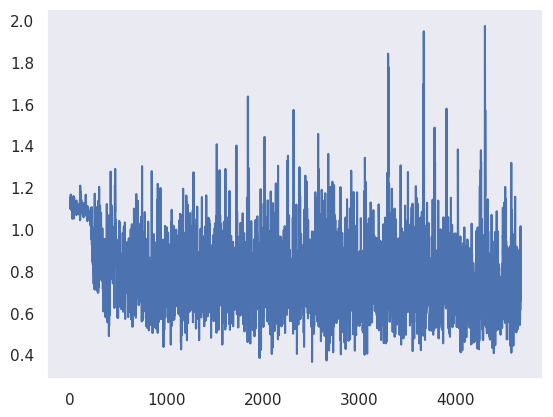

In [36]:
plt.plot(train_losses)

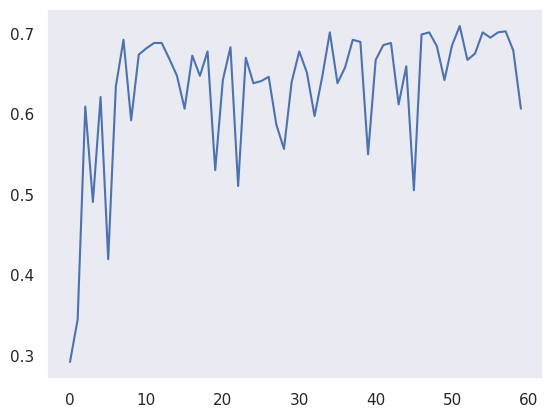

In [37]:
plt.plot(test_accuracy)

In [38]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 461/736 (0.6264)
{'acc_detail': tensor([0.6500, 0.2318, 0.9414], device='cuda:0'),
 'acc_unweighted': tensor(0.6077, device='cuda:0'),
 'acc_weighted': tensor(0.6264, device='cuda:0'),
 'f1s': tensor(0.5897, device='cuda:0'),
 'f1s_detail': tensor([0.7735, 0.2890, 0.7067], device='cuda:0'),
 'precision_detail': tensor([0.9548, 0.3835, 0.5657], device='cuda:0'),
 'recall_detail': tensor([0.6500, 0.2318, 0.9414], device='cuda:0'),
 'rocauc': tensor([0.9618, 0.7266, 0.9080], device='cuda:0'),
 'uar': tensor(0.6077, device='cuda:0'),
 'wap': tensor(0.6487, device='cuda:0')}


tensor([[169,  69,  22],
        [  6,  51, 163],
        [  2,  13, 241]], device='cuda:0')

In [39]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [40]:
best_epoch = 52
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 538/736 (0.7310)
{'acc_detail': tensor([0.8417, 0.5324, 0.7854], device='cuda:0'),
 'acc_unweighted': tensor(0.7198, device='cuda:0'),
 'acc_weighted': tensor(0.7310, device='cuda:0'),
 'f1s': tensor(0.7187, device='cuda:0'),
 'f1s_detail': tensor([0.8385, 0.5542, 0.7635], device='cuda:0'),
 'precision_detail': tensor([0.8352, 0.5779, 0.7428], device='cuda:0'),
 'recall_detail': tensor([0.8417, 0.5324, 0.7854], device='cuda:0'),
 'rocauc': tensor([0.9578, 0.8043, 0.9028], device='cuda:0'),
 'uar': tensor(0.7198, device='cuda:0'),
 'wap': tensor(0.7269, device='cuda:0')}


tensor([[218,  39,   2],
        [ 32, 115,  69],
        [ 11,  45, 205]], device='cuda:0')

In [41]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [42]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/40 [00:00<12:54, 19.36s/it]

Train Epoch: 61 [0/2508 (0%)]	Loss: 0.716139
Mem before-during-after: 22078464 110024704 23134720


  1%|█▊                                                                                                                                                                             | 0.41584158415841604/40 [00:07<12:32, 19.00s/it]

Train Epoch: 61 [1280/2508 (51%)]	Loss: 0.762267
Mem before-during-after: 23134720 111076864 23134720


  3%|████▍                                                                                                                                                                           | 1.0099009900990106/40 [00:18<12:01, 18.51s/it]


Test Epoch: 61	Accuracy: 540/736 (71%)

saved model: ../models_cremad3/cremad_label3_m12new_best_61epoch.pt
Train Epoch: 62 [0/2508 (0%)]	Loss: 0.649303
Mem before-during-after: 23130624 111076864 23134720


  4%|██████▏                                                                                                                                                                         | 1.4158415841584169/40 [00:26<12:04, 18.79s/it]

Train Epoch: 62 [1280/2508 (51%)]	Loss: 0.587402
Mem before-during-after: 23134720 111076864 23134720


  5%|████████▊                                                                                                                                                                       | 2.0099009900990112/40 [00:37<11:52, 18.76s/it]


Test Epoch: 62	Accuracy: 531/736 (70%)

Train Epoch: 63 [0/2508 (0%)]	Loss: 0.517664
Mem before-during-after: 23130624 111076864 23134720


  6%|██████████▋                                                                                                                                                                     | 2.4158415841584175/40 [00:45<11:45, 18.76s/it]

Train Epoch: 63 [1280/2508 (51%)]	Loss: 0.478880
Mem before-during-after: 23134720 111076864 23134720


  8%|█████████████▎                                                                                                                                                                   | 3.009900990099012/40 [00:56<11:28, 18.61s/it]


Test Epoch: 63	Accuracy: 547/736 (72%)

saved model: ../models_cremad3/cremad_label3_m12new_best_63epoch.pt
Train Epoch: 64 [0/2508 (0%)]	Loss: 1.138748
Mem before-during-after: 23130624 111076864 23134720


  9%|███████████████                                                                                                                                                                 | 3.4158415841584184/40 [01:04<11:31, 18.90s/it]

Train Epoch: 64 [1280/2508 (51%)]	Loss: 0.690801
Mem before-during-after: 23134720 111076864 23134720


 10%|█████████████████▋                                                                                                                                                               | 4.009900990099013/40 [01:15<11:23, 18.98s/it]


Test Epoch: 64	Accuracy: 543/736 (72%)

Train Epoch: 65 [0/2508 (0%)]	Loss: 0.543197
Mem before-during-after: 23130624 111076864 23134720


 11%|███████████████████▌                                                                                                                                                             | 4.415841584158419/40 [01:23<11:22, 19.18s/it]

Train Epoch: 65 [1280/2508 (51%)]	Loss: 0.567969
Mem before-during-after: 23134720 111076864 23134720


 13%|██████████████████████                                                                                                                                                          | 5.0099009900990135/40 [01:34<10:56, 18.76s/it]


Test Epoch: 65	Accuracy: 541/736 (71%)

Train Epoch: 66 [0/2508 (0%)]	Loss: 0.481901
Mem before-during-after: 23130624 111076864 23134720


 14%|████████████████████████                                                                                                                                                          | 5.41584158415842/40 [01:42<10:56, 18.98s/it]

Train Epoch: 66 [1280/2508 (51%)]	Loss: 0.486773
Mem before-during-after: 23134720 111076864 23134720


 15%|██████████████████████████▌                                                                                                                                                      | 6.009900990099014/40 [01:53<10:22, 18.31s/it]


Test Epoch: 66	Accuracy: 525/736 (69%)

Train Epoch: 67 [0/2508 (0%)]	Loss: 0.686670
Mem before-during-after: 23130624 111076864 23134720


 16%|████████████████████████████▍                                                                                                                                                    | 6.415841584158421/40 [02:00<10:25, 18.64s/it]

Train Epoch: 67 [1280/2508 (51%)]	Loss: 0.658368
Mem before-during-after: 23134720 111076864 23134720


 18%|███████████████████████████████                                                                                                                                                  | 7.009900990099015/40 [02:12<10:16, 18.70s/it]


Test Epoch: 67	Accuracy: 537/736 (71%)

Train Epoch: 68 [0/2508 (0%)]	Loss: 0.638185
Mem before-during-after: 23130624 111076864 23134720


 19%|████████████████████████████████▋                                                                                                                                               | 7.4158415841584215/40 [02:19<10:18, 18.97s/it]

Train Epoch: 68 [1280/2508 (51%)]	Loss: 0.665604
Mem before-during-after: 23134720 111076864 23134720


 20%|███████████████████████████████████▍                                                                                                                                             | 8.009900990099014/40 [02:30<09:44, 18.26s/it]


Test Epoch: 68	Accuracy: 541/736 (71%)

Train Epoch: 69 [0/2508 (0%)]	Loss: 0.638031
Mem before-during-after: 23130624 111076864 23134720


 21%|█████████████████████████████████████▏                                                                                                                                           | 8.415841584158384/40 [02:38<09:46, 18.58s/it]

Train Epoch: 69 [1280/2508 (51%)]	Loss: 0.628147
Mem before-during-after: 23134720 111076864 23134720


 23%|███████████████████████████████████████▊                                                                                                                                         | 9.009900990098926/40 [02:49<09:29, 18.39s/it]


Test Epoch: 69	Accuracy: 532/736 (70%)

Train Epoch: 70 [0/2508 (0%)]	Loss: 0.680129
Mem before-during-after: 23130624 111076864 23134720


 24%|█████████████████████████████████████████▋                                                                                                                                       | 9.415841584158295/40 [02:57<10:22, 20.36s/it]

Train Epoch: 70 [1280/2508 (51%)]	Loss: 0.834217
Mem before-during-after: 23134720 111076864 23134720


 25%|████████████████████████████████████████████                                                                                                                                    | 10.009900990098837/40 [03:08<09:11, 18.40s/it]


Test Epoch: 70	Accuracy: 549/736 (72%)

saved model: ../models_cremad3/cremad_label3_m12new_best_70epoch.pt
Train Epoch: 71 [0/2508 (0%)]	Loss: 0.624322
Mem before-during-after: 23130624 111076864 23134720


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 10.415841584158207/40 [03:16<09:30, 19.27s/it]

Train Epoch: 71 [1280/2508 (51%)]	Loss: 0.719387
Mem before-during-after: 23134720 111076864 23134720


 27%|████████████████████████████████████████████████▍                                                                                                                               | 10.999999999999739/40 [03:27<08:48, 18.21s/it]


Test Epoch: 71	Accuracy: 543/736 (72%)



 28%|████████████████████████████████████████████████▍                                                                                                                               | 11.019801980197757/40 [03:28<09:12, 19.06s/it]

Train Epoch: 72 [0/2508 (0%)]	Loss: 0.865911
Mem before-during-after: 23130624 111076864 23134720


 29%|██████████████████████████████████████████████████▏                                                                                                                             | 11.415841584158118/40 [03:35<09:18, 19.55s/it]

Train Epoch: 72 [1280/2508 (51%)]	Loss: 0.705216
Mem before-during-after: 23134720 111076864 23134720


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 12.009900990098659/40 [03:47<08:49, 18.92s/it]


Test Epoch: 72	Accuracy: 554/736 (73%)

saved model: ../models_cremad3/cremad_label3_m12new_best_72epoch.pt
Train Epoch: 73 [0/2508 (0%)]	Loss: 0.469865
Mem before-during-after: 23130624 111076864 23134720


 31%|██████████████████████████████████████████████████████▋                                                                                                                         | 12.415841584158029/40 [03:55<08:43, 19.00s/it]

Train Epoch: 73 [1280/2508 (51%)]	Loss: 0.711585
Mem before-during-after: 23134720 111076864 23134720


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13.00990099009857/40 [04:06<08:16, 18.40s/it]


Test Epoch: 73	Accuracy: 548/736 (72%)

Train Epoch: 74 [0/2508 (0%)]	Loss: 0.831413
Mem before-during-after: 23130624 111076864 23134720


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 13.41584158415794/40 [04:13<08:16, 18.69s/it]

Train Epoch: 74 [1280/2508 (51%)]	Loss: 0.632441
Mem before-during-after: 23134720 111076864 23134720


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                  | 14.009900990098481/40 [04:24<08:02, 18.57s/it]


Test Epoch: 74	Accuracy: 540/736 (71%)

Train Epoch: 75 [0/2508 (0%)]	Loss: 0.845903
Mem before-during-after: 23130624 111076864 23134720


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 14.415841584157851/40 [04:32<08:41, 20.38s/it]

Train Epoch: 75 [1280/2508 (51%)]	Loss: 0.511249
Mem before-during-after: 23134720 111076864 23134720


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 15.009900990098393/40 [04:43<07:45, 18.61s/it]


Test Epoch: 75	Accuracy: 557/736 (73%)

saved model: ../models_cremad3/cremad_label3_m12new_best_75epoch.pt
Train Epoch: 76 [0/2508 (0%)]	Loss: 0.542143
Mem before-during-after: 23130624 111076864 23134720


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 15.415841584157763/40 [04:51<07:45, 18.94s/it]

Train Epoch: 76 [1280/2508 (51%)]	Loss: 0.651880
Mem before-during-after: 23134720 111076864 23134720


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 16.009900990098306/40 [05:02<07:28, 18.71s/it]


Test Epoch: 76	Accuracy: 556/736 (73%)

Train Epoch: 77 [0/2508 (0%)]	Loss: 0.614529
Mem before-during-after: 23130624 111076864 23134720


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 16.415841584157675/40 [05:10<07:31, 19.13s/it]

Train Epoch: 77 [1280/2508 (51%)]	Loss: 0.837084
Mem before-during-after: 23134720 111076864 23134720


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 17.009900990098217/40 [05:21<07:05, 18.51s/it]


Test Epoch: 77	Accuracy: 544/736 (72%)

Train Epoch: 78 [0/2508 (0%)]	Loss: 0.722958
Mem before-during-after: 23130624 111076864 23134720


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 17.415841584157587/40 [05:29<07:03, 18.75s/it]

Train Epoch: 78 [1280/2508 (51%)]	Loss: 0.806699
Mem before-during-after: 23134720 111076864 23134720


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 18.009900990098128/40 [05:40<06:47, 18.54s/it]


Test Epoch: 78	Accuracy: 546/736 (72%)

Train Epoch: 79 [0/2508 (0%)]	Loss: 0.739316
Mem before-during-after: 23130624 111076864 23134720


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 18.415841584157498/40 [05:47<06:45, 18.77s/it]

Train Epoch: 79 [1280/2508 (51%)]	Loss: 0.766909
Mem before-during-after: 23134720 111076864 23134720


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19.00990099009804/40 [05:59<06:27, 18.46s/it]


Test Epoch: 79	Accuracy: 550/736 (72%)

Train Epoch: 80 [0/2508 (0%)]	Loss: 0.669831
Mem before-during-after: 23130624 111076864 23134720


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 19.41584158415741/40 [06:06<06:25, 18.74s/it]

Train Epoch: 80 [1280/2508 (51%)]	Loss: 0.789747
Mem before-during-after: 23134720 111076864 23134720


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20.00990099009795/40 [06:17<06:10, 18.52s/it]


Test Epoch: 80	Accuracy: 542/736 (71%)

Train Epoch: 81 [0/2508 (0%)]	Loss: 0.632968
Mem before-during-after: 23130624 111076864 23134720


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 20.41584158415732/40 [06:25<06:08, 18.81s/it]

Train Epoch: 81 [1280/2508 (51%)]	Loss: 0.709161
Mem before-during-after: 23134720 111076864 23134720


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21.00990099009786/40 [06:36<05:49, 18.42s/it]


Test Epoch: 81	Accuracy: 555/736 (73%)

Train Epoch: 82 [0/2508 (0%)]	Loss: 0.565492
Mem before-during-after: 23130624 111076864 23134720


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 21.405940594058222/40 [06:44<05:56, 19.17s/it]

Train Epoch: 82 [1280/2508 (51%)]	Loss: 0.747143
Mem before-during-after: 23134720 111076864 23134720


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 21.999999999998764/40 [06:55<06:23, 21.30s/it]


Test Epoch: 82	Accuracy: 532/736 (70%)



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 22.01980198019678/40 [06:55<06:10, 20.62s/it]

Train Epoch: 83 [0/2508 (0%)]	Loss: 0.487905
Mem before-during-after: 23130624 111076864 23134720


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 22.415841584157143/40 [07:03<05:44, 19.60s/it]

Train Epoch: 83 [1280/2508 (51%)]	Loss: 0.526132
Mem before-during-after: 23134720 111076864 23134720


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23.009900990097684/40 [07:14<05:11, 18.36s/it]


Test Epoch: 83	Accuracy: 346/736 (46%)

Train Epoch: 84 [0/2508 (0%)]	Loss: 1.228601
Mem before-during-after: 23130624 111076864 23134720


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 23.415841584157054/40 [07:22<05:09, 18.66s/it]

Train Epoch: 84 [1280/2508 (51%)]	Loss: 0.632097
Mem before-during-after: 23134720 111076864 23134720


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 24.009900990097595/40 [07:33<04:52, 18.30s/it]


Test Epoch: 84	Accuracy: 545/736 (72%)

Train Epoch: 85 [0/2508 (0%)]	Loss: 0.668109
Mem before-during-after: 23130624 111076864 23134720


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 24.415841584156965/40 [07:40<04:52, 18.77s/it]

Train Epoch: 85 [1280/2508 (51%)]	Loss: 0.532847
Mem before-during-after: 23134720 111076864 23134720


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 25.009900990097506/40 [07:51<04:35, 18.37s/it]


Test Epoch: 85	Accuracy: 545/736 (72%)

Train Epoch: 86 [0/2508 (0%)]	Loss: 0.559078
Mem before-during-after: 23130624 111076864 23134720


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 25.415841584156876/40 [07:59<04:35, 18.86s/it]

Train Epoch: 86 [1280/2508 (51%)]	Loss: 0.753537
Mem before-during-after: 23134720 111076864 23134720


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 26.009900990097417/40 [08:10<04:19, 18.54s/it]


Test Epoch: 86	Accuracy: 565/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_86epoch.pt
Train Epoch: 87 [0/2508 (0%)]	Loss: 0.742895
Mem before-during-after: 23130624 111076864 23134720


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 26.415841584156787/40 [08:18<04:23, 19.37s/it]

Train Epoch: 87 [1280/2508 (51%)]	Loss: 0.490701
Mem before-during-after: 23134720 111076864 23134720


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 27.00990099009733/40 [08:29<04:13, 19.52s/it]


Test Epoch: 87	Accuracy: 543/736 (72%)

Train Epoch: 88 [0/2508 (0%)]	Loss: 0.677279
Mem before-during-after: 23130624 111076864 23134720


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27.4158415841567/40 [08:37<03:59, 19.02s/it]

Train Epoch: 88 [1280/2508 (51%)]	Loss: 0.721291
Mem before-during-after: 23134720 111076864 23134720


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28.00990099009724/40 [08:48<03:41, 18.50s/it]


Test Epoch: 88	Accuracy: 528/736 (70%)

Train Epoch: 89 [0/2508 (0%)]	Loss: 0.984187
Mem before-during-after: 23130624 111076864 23134720


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28.41584158415661/40 [08:56<03:35, 18.63s/it]

Train Epoch: 89 [1280/2508 (51%)]	Loss: 0.655802
Mem before-during-after: 23134720 111076864 23134720


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29.00990099009715/40 [09:07<03:29, 19.09s/it]


Test Epoch: 89	Accuracy: 572/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_89epoch.pt
Train Epoch: 90 [0/2508 (0%)]	Loss: 0.677357
Mem before-during-after: 23130624 111076864 23134720


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29.41584158415652/40 [09:15<03:24, 19.33s/it]

Train Epoch: 90 [1280/2508 (51%)]	Loss: 0.846446
Mem before-during-after: 23134720 111076864 23134720


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30.009900990097062/40 [09:26<03:03, 18.35s/it]


Test Epoch: 90	Accuracy: 568/736 (75%)

Train Epoch: 91 [0/2508 (0%)]	Loss: 0.652382
Mem before-during-after: 23130624 111076864 23134720


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30.415841584156432/40 [09:34<02:59, 18.70s/it]

Train Epoch: 91 [1280/2508 (51%)]	Loss: 0.872756
Mem before-during-after: 23134720 111076864 23134720


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31.009900990096973/40 [09:45<02:43, 18.17s/it]


Test Epoch: 91	Accuracy: 473/736 (62%)

Train Epoch: 92 [0/2508 (0%)]	Loss: 0.944045
Mem before-during-after: 23130624 111076864 23134720


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 31.415841584156343/40 [09:53<02:42, 18.93s/it]

Train Epoch: 92 [1280/2508 (51%)]	Loss: 0.546809
Mem before-during-after: 23134720 111076864 23134720


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 32.00990099009689/40 [10:04<02:27, 18.51s/it]


Test Epoch: 92	Accuracy: 429/736 (57%)

Train Epoch: 93 [0/2508 (0%)]	Loss: 0.894315
Mem before-during-after: 23130624 111076864 23134720


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 32.415841584156404/40 [10:12<02:23, 18.90s/it]

Train Epoch: 93 [1280/2508 (51%)]	Loss: 0.733317
Mem before-during-after: 23134720 111076864 23134720


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33.00990099009716/40 [10:23<02:10, 18.71s/it]


Test Epoch: 93	Accuracy: 573/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_93epoch.pt
Train Epoch: 94 [0/2508 (0%)]	Loss: 0.647143
Mem before-during-after: 23130624 111076864 23134720


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 33.415841584156674/40 [10:31<02:01, 18.50s/it]

Train Epoch: 94 [1280/2508 (51%)]	Loss: 0.866478
Mem before-during-after: 23134720 111076864 23134720


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34.00990099009743/40 [10:42<01:53, 18.95s/it]


Test Epoch: 94	Accuracy: 560/736 (74%)

Train Epoch: 95 [0/2508 (0%)]	Loss: 0.368914
Mem before-during-after: 23130624 111076864 23134720


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 34.415841584156944/40 [10:50<01:47, 19.30s/it]

Train Epoch: 95 [1280/2508 (51%)]	Loss: 0.764152
Mem before-during-after: 23134720 111076864 23134720


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 35.0099009900977/40 [11:01<01:33, 18.74s/it]


Test Epoch: 95	Accuracy: 554/736 (73%)

Train Epoch: 96 [0/2508 (0%)]	Loss: 0.577912
Mem before-during-after: 23130624 111076864 23134720


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 35.415841584157214/40 [11:09<01:27, 19.07s/it]

Train Epoch: 96 [1280/2508 (51%)]	Loss: 1.222388
Mem before-during-after: 23134720 111076864 23134720


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36.00990099009797/40 [11:20<01:15, 18.87s/it]


Test Epoch: 96	Accuracy: 558/736 (74%)

Train Epoch: 97 [0/2508 (0%)]	Loss: 0.827938
Mem before-during-after: 23130624 111076864 23134720


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 36.415841584157484/40 [11:28<01:07, 18.71s/it]

Train Epoch: 97 [1280/2508 (51%)]	Loss: 0.381909
Mem before-during-after: 23134720 111076864 23134720


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 37.00990099009824/40 [11:39<00:54, 18.31s/it]


Test Epoch: 97	Accuracy: 566/736 (75%)

Train Epoch: 98 [0/2508 (0%)]	Loss: 0.654213
Mem before-during-after: 23130624 111076864 23134720


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37.415841584157754/40 [11:46<00:48, 18.87s/it]

Train Epoch: 98 [1280/2508 (51%)]	Loss: 0.537651
Mem before-during-after: 23134720 111076864 23134720


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38.00990099009851/40 [11:57<00:36, 18.48s/it]


Test Epoch: 98	Accuracy: 551/736 (73%)

Train Epoch: 99 [0/2508 (0%)]	Loss: 0.679407
Mem before-during-after: 23130624 111076864 23134720


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 38.415841584158024/40 [12:05<00:30, 19.05s/it]

Train Epoch: 99 [1280/2508 (51%)]	Loss: 0.856407
Mem before-during-after: 23134720 111076864 23134720


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39.00990099009878/40 [12:16<00:18, 18.72s/it]


Test Epoch: 99	Accuracy: 578/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_99epoch.pt
Train Epoch: 100 [0/2508 (0%)]	Loss: 0.688722
Mem before-during-after: 23130624 111076864 23134720


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 39.415841584158294/40 [12:24<00:11, 19.03s/it]

Train Epoch: 100 [1280/2508 (51%)]	Loss: 0.669510
Mem before-during-after: 23134720 111076864 23134720


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40.000000000000036/40 [12:35<00:00, 18.89s/it]


Test Epoch: 100	Accuracy: 527/736 (69%)



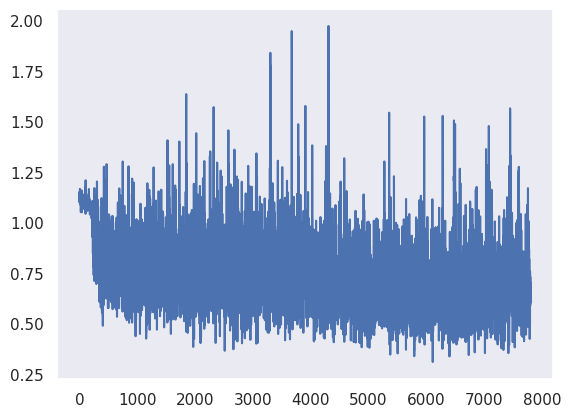

In [44]:
plt.plot(train_losses)

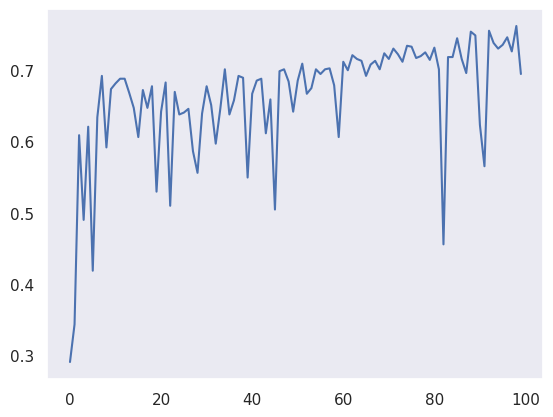

In [45]:
plt.plot(test_accuracy)

In [46]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 527/736 (0.7160)
{'acc_detail': tensor([0.8378, 0.3455, 0.9105], device='cuda:0'),
 'acc_unweighted': tensor(0.6979, device='cuda:0'),
 'acc_weighted': tensor(0.7160, device='cuda:0'),
 'f1s': tensor(0.6859, device='cuda:0'),
 'f1s_detail': tensor([0.8768, 0.4380, 0.7429], device='cuda:0'),
 'precision_detail': tensor([0.9195, 0.5984, 0.6273], device='cuda:0'),
 'recall_detail': tensor([0.8378, 0.3455, 0.9105], device='cuda:0'),
 'rocauc': tensor([0.9735, 0.8312, 0.9196], device='cuda:0'),
 'uar': tensor(0.6979, device='cuda:0'),
 'wap': tensor(0.7215, device='cuda:0')}


tensor([[217,  33,   9],
        [ 14,  76, 130],
        [  5,  18, 234]], device='cuda:0')

In [47]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [48]:
best_epoch = 99
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 578/736 (0.7853)
{'acc_detail': tensor([0.8889, 0.7222, 0.7336], device='cuda:0'),
 'acc_unweighted': tensor(0.7816, device='cuda:0'),
 'acc_weighted': tensor(0.7853, device='cuda:0'),
 'f1s': tensor(0.7806, device='cuda:0'),
 'f1s_detail': tensor([0.8738, 0.6797, 0.7884], device='cuda:0'),
 'precision_detail': tensor([0.8593, 0.6420, 0.8520], device='cuda:0'),
 'recall_detail': tensor([0.8889, 0.7222, 0.7336], device='cuda:0'),
 'rocauc': tensor([0.9752, 0.8625, 0.9229], device='cuda:0'),
 'uar': tensor(0.7816, device='cuda:0'),
 'wap': tensor(0.7929, device='cuda:0')}


tensor([[232,  29,   0],
        [ 27, 156,  33],
        [ 11,  58, 190]], device='cuda:0')

In [49]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [50]:
np.save('../cremad3_m12new_100epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_m12new_100epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [51]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+100, n_epoch4+100 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:19, 19.59s/it]

Train Epoch: 101 [0/2508 (0%)]	Loss: 0.443376
Mem before-during-after: 23301120 111201792 24311808


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:08<15:44, 19.06s/it]

Train Epoch: 101 [1280/2508 (51%)]	Loss: 0.764125
Mem before-during-after: 24311808 112253952 24311808


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:19<15:20, 18.78s/it]


Test Epoch: 101	Accuracy: 559/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_101epoch.pt
Train Epoch: 102 [0/2508 (0%)]	Loss: 0.833322
Mem before-during-after: 24307712 112253952 24311808


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:27<15:22, 19.00s/it]

Train Epoch: 102 [1280/2508 (51%)]	Loss: 0.682465
Mem before-during-after: 24311808 112253952 24311808


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:38<15:02, 18.81s/it]


Test Epoch: 102	Accuracy: 564/736 (74%)

saved model: ../models_cremad3/cremad_label3_m12new_best_102epoch.pt
Train Epoch: 103 [0/2508 (0%)]	Loss: 0.610006
Mem before-during-after: 24307712 112253952 24311808


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:45<14:57, 18.87s/it]

Train Epoch: 103 [1280/2508 (51%)]	Loss: 0.624826
Mem before-during-after: 24311808 112253952 24311808


  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [00:57<14:43, 18.81s/it]


Test Epoch: 103	Accuracy: 571/736 (75%)

saved model: ../models_cremad3/cremad_label3_m12new_best_103epoch.pt
Train Epoch: 104 [0/2508 (0%)]	Loss: 0.816531
Mem before-during-after: 24307712 112253952 24311808


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:04<14:49, 19.10s/it]

Train Epoch: 104 [1280/2508 (51%)]	Loss: 0.637527
Mem before-during-after: 24311808 112253952 24311808


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:16<14:25, 18.81s/it]


Test Epoch: 104	Accuracy: 580/736 (76%)

saved model: ../models_cremad3/cremad_label3_m12new_best_104epoch.pt
Train Epoch: 105 [0/2508 (0%)]	Loss: 0.510634
Mem before-during-after: 24307712 112253952 24311808


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:23<14:34, 19.19s/it]

Train Epoch: 105 [1280/2508 (51%)]	Loss: 0.618109
Mem before-during-after: 24311808 112253952 24311808


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:35<14:00, 18.69s/it]


Test Epoch: 105	Accuracy: 559/736 (74%)

Train Epoch: 106 [0/2508 (0%)]	Loss: 0.417429
Mem before-during-after: 24307712 112253952 24311808


 11%|███████████████████▎                                                                                                                                                              | 5.41584158415842/50 [01:42<13:58, 18.80s/it]

Train Epoch: 106 [1280/2508 (51%)]	Loss: 0.445509
Mem before-during-after: 24311808 112253952 24311808


 12%|█████████████████████▎                                                                                                                                                           | 6.009900990099014/50 [01:53<13:41, 18.67s/it]


Test Epoch: 106	Accuracy: 567/736 (75%)

Train Epoch: 107 [0/2508 (0%)]	Loss: 0.403998
Mem before-during-after: 24307712 112253952 24311808


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:01<14:31, 19.99s/it]

Train Epoch: 107 [1280/2508 (51%)]	Loss: 0.633545
Mem before-during-after: 24311808 112253952 24311808


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:13<14:13, 19.86s/it]


Test Epoch: 107	Accuracy: 568/736 (75%)

Train Epoch: 108 [0/2508 (0%)]	Loss: 0.651252
Mem before-during-after: 24307712 112253952 24311808


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:20<13:22, 18.84s/it]

Train Epoch: 108 [1280/2508 (51%)]	Loss: 0.457032
Mem before-during-after: 24311808 112253952 24311808


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [02:31<13:01, 18.62s/it]


Test Epoch: 108	Accuracy: 579/736 (76%)

Train Epoch: 109 [0/2508 (0%)]	Loss: 0.418294
Mem before-during-after: 24307712 112253952 24311808


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:39<13:01, 18.80s/it]

Train Epoch: 109 [1280/2508 (51%)]	Loss: 0.742227
Mem before-during-after: 24311808 112253952 24311808


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:50<12:42, 18.59s/it]


Test Epoch: 109	Accuracy: 571/736 (75%)

Train Epoch: 110 [0/2508 (0%)]	Loss: 0.566043
Mem before-during-after: 24307712 112253952 24311808


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [02:58<12:53, 19.07s/it]

Train Epoch: 110 [1280/2508 (51%)]	Loss: 0.492904
Mem before-during-after: 24311808 112253952 24311808


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:09<12:19, 18.50s/it]


Test Epoch: 110	Accuracy: 554/736 (73%)

Train Epoch: 111 [0/2508 (0%)]	Loss: 0.855940
Mem before-during-after: 24307712 112253952 24311808


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:17<12:29, 18.93s/it]

Train Epoch: 111 [1280/2508 (51%)]	Loss: 0.535085
Mem before-during-after: 24311808 112253952 24311808


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:28<12:05, 18.60s/it]


Test Epoch: 111	Accuracy: 581/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_111epoch.pt
Train Epoch: 112 [0/2508 (0%)]	Loss: 0.630263
Mem before-during-after: 24307712 112253952 24311808


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.415841584158118/50 [03:36<12:05, 18.79s/it]

Train Epoch: 112 [1280/2508 (51%)]	Loss: 0.506490
Mem before-during-after: 24311808 112253952 24311808


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:47<11:55, 18.83s/it]


Test Epoch: 112	Accuracy: 584/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_112epoch.pt
Train Epoch: 113 [0/2508 (0%)]	Loss: 0.810287
Mem before-during-after: 24307712 112253952 24311808


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [03:54<11:49, 18.87s/it]

Train Epoch: 113 [1280/2508 (51%)]	Loss: 0.835069
Mem before-during-after: 24311808 112253952 24311808


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.00990099009857/50 [04:06<11:36, 18.83s/it]


Test Epoch: 113	Accuracy: 578/736 (76%)

Train Epoch: 114 [0/2508 (0%)]	Loss: 0.581174
Mem before-during-after: 24307712 112253952 24311808


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:13<11:35, 19.02s/it]

Train Epoch: 114 [1280/2508 (51%)]	Loss: 0.455329
Mem before-during-after: 24311808 112253952 24311808


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:25<11:24, 19.02s/it]


Test Epoch: 114	Accuracy: 575/736 (76%)

Train Epoch: 115 [0/2508 (0%)]	Loss: 0.642556
Mem before-during-after: 24307712 112253952 24311808


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:33<11:25, 19.26s/it]

Train Epoch: 115 [1280/2508 (51%)]	Loss: 0.591005
Mem before-during-after: 24311808 112253952 24311808


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:44<10:54, 18.70s/it]


Test Epoch: 115	Accuracy: 584/736 (77%)

Train Epoch: 116 [0/2508 (0%)]	Loss: 0.535062
Mem before-during-after: 24307712 112253952 24311808


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [04:52<11:05, 19.26s/it]

Train Epoch: 116 [1280/2508 (51%)]	Loss: 0.666716
Mem before-during-after: 24311808 112253952 24311808


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [05:03<10:53, 19.22s/it]


Test Epoch: 116	Accuracy: 562/736 (74%)

Train Epoch: 117 [0/2508 (0%)]	Loss: 0.792804
Mem before-during-after: 24307712 112253952 24311808


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:11<10:51, 19.41s/it]

Train Epoch: 117 [1280/2508 (51%)]	Loss: 0.848423
Mem before-during-after: 24311808 112253952 24311808


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:22<10:19, 18.78s/it]


Test Epoch: 117	Accuracy: 585/736 (77%)

saved model: ../models_cremad3/cremad_label3_m12new_best_117epoch.pt
Train Epoch: 118 [0/2508 (0%)]	Loss: 0.375847
Mem before-during-after: 24307712 112253952 24311808


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:30<10:17, 18.95s/it]

Train Epoch: 118 [1280/2508 (51%)]	Loss: 0.483957
Mem before-during-after: 24311808 112253952 24311808


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:41<10:03, 18.88s/it]


Test Epoch: 118	Accuracy: 557/736 (73%)

Train Epoch: 119 [0/2508 (0%)]	Loss: 0.548672
Mem before-during-after: 24307712 112253952 24311808


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [05:49<10:04, 19.15s/it]

Train Epoch: 119 [1280/2508 (51%)]	Loss: 0.780865
Mem before-during-after: 24311808 112253952 24311808


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [06:00<09:44, 18.87s/it]


Test Epoch: 119	Accuracy: 564/736 (74%)

Train Epoch: 120 [0/2508 (0%)]	Loss: 0.820638
Mem before-during-after: 24307712 112253952 24311808


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:08<09:46, 19.18s/it]

Train Epoch: 120 [1280/2508 (51%)]	Loss: 0.691490
Mem before-during-after: 24311808 112253952 24311808


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00990099009795/50 [06:19<09:29, 19.00s/it]


Test Epoch: 120	Accuracy: 591/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_120epoch.pt
Train Epoch: 121 [0/2508 (0%)]	Loss: 0.692176
Mem before-during-after: 24307712 112253952 24311808


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:27<09:29, 19.26s/it]

Train Epoch: 121 [1280/2508 (51%)]	Loss: 0.799134
Mem before-during-after: 24311808 112253952 24311808


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:39<09:21, 19.38s/it]


Test Epoch: 121	Accuracy: 595/736 (78%)

saved model: ../models_cremad3/cremad_label3_m12new_best_121epoch.pt
Train Epoch: 122 [0/2508 (0%)]	Loss: 0.493729
Mem before-during-after: 24307712 112253952 24311808


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [06:47<09:13, 19.36s/it]

Train Epoch: 122 [1280/2508 (51%)]	Loss: 0.714004
Mem before-during-after: 24311808 112253952 24311808


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [06:58<08:49, 18.93s/it]


Test Epoch: 122	Accuracy: 561/736 (74%)

Train Epoch: 123 [0/2508 (0%)]	Loss: 0.488029
Mem before-during-after: 24307712 112253952 24311808


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [07:06<08:52, 19.32s/it]

Train Epoch: 123 [1280/2508 (51%)]	Loss: 0.666481
Mem before-during-after: 24311808 112253952 24311808


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:17<08:21, 18.57s/it]


Test Epoch: 123	Accuracy: 565/736 (74%)

Train Epoch: 124 [0/2508 (0%)]	Loss: 0.445771
Mem before-during-after: 24307712 112253952 24311808


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:25<08:19, 18.80s/it]

Train Epoch: 124 [1280/2508 (51%)]	Loss: 0.559292
Mem before-during-after: 24311808 112253952 24311808


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:36<08:13, 18.98s/it]


Test Epoch: 124	Accuracy: 588/736 (77%)

Train Epoch: 125 [0/2508 (0%)]	Loss: 0.540088
Mem before-during-after: 24307712 112253952 24311808


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [07:44<08:04, 18.92s/it]

Train Epoch: 125 [1280/2508 (51%)]	Loss: 0.402825
Mem before-during-after: 24311808 112253952 24311808


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [07:55<07:43, 18.56s/it]


Test Epoch: 125	Accuracy: 578/736 (76%)

Train Epoch: 126 [0/2508 (0%)]	Loss: 0.577709
Mem before-during-after: 24307712 112253952 24311808


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [08:03<07:42, 18.82s/it]

Train Epoch: 126 [1280/2508 (51%)]	Loss: 0.445457
Mem before-during-after: 24311808 112253952 24311808


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.009900990097417/50 [08:14<07:26, 18.60s/it]


Test Epoch: 126	Accuracy: 546/736 (72%)

Train Epoch: 127 [0/2508 (0%)]	Loss: 0.584876
Mem before-during-after: 24307712 112253952 24311808


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:21<07:25, 18.90s/it]

Train Epoch: 127 [1280/2508 (51%)]	Loss: 0.777377
Mem before-during-after: 24311808 112253952 24311808


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:33<07:10, 18.71s/it]


Test Epoch: 127	Accuracy: 524/736 (69%)

Train Epoch: 128 [0/2508 (0%)]	Loss: 0.722819
Mem before-during-after: 24307712 112253952 24311808


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [08:40<07:09, 19.02s/it]

Train Epoch: 128 [1280/2508 (51%)]	Loss: 0.499707
Mem before-during-after: 24311808 112253952 24311808


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [08:51<06:48, 18.56s/it]


Test Epoch: 128	Accuracy: 578/736 (76%)

Train Epoch: 129 [0/2508 (0%)]	Loss: 0.455099
Mem before-during-after: 24307712 112253952 24311808


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [08:59<06:46, 18.85s/it]

Train Epoch: 129 [1280/2508 (51%)]	Loss: 0.628037
Mem before-during-after: 24311808 112253952 24311808


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.00990099009715/50 [09:10<06:27, 18.47s/it]


Test Epoch: 129	Accuracy: 589/736 (78%)

Train Epoch: 130 [0/2508 (0%)]	Loss: 0.635295
Mem before-during-after: 24307712 112253952 24311808


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:18<06:28, 18.90s/it]

Train Epoch: 130 [1280/2508 (51%)]	Loss: 0.669534
Mem before-during-after: 24311808 112253952 24311808


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:29<06:11, 18.61s/it]


Test Epoch: 130	Accuracy: 576/736 (76%)

Train Epoch: 131 [0/2508 (0%)]	Loss: 0.651317
Mem before-during-after: 24307712 112253952 24311808


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:37<06:07, 18.77s/it]

Train Epoch: 131 [1280/2508 (51%)]	Loss: 0.766011
Mem before-during-after: 24311808 112253952 24311808


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.009900990096973/50 [09:48<05:52, 18.56s/it]


Test Epoch: 131	Accuracy: 564/736 (74%)

Train Epoch: 132 [0/2508 (0%)]	Loss: 0.555794
Mem before-during-after: 24307712 112253952 24311808


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [09:56<05:50, 18.87s/it]

Train Epoch: 132 [1280/2508 (51%)]	Loss: 0.618597
Mem before-during-after: 24311808 112253952 24311808


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [10:07<05:33, 18.55s/it]


Test Epoch: 132	Accuracy: 589/736 (78%)

Train Epoch: 133 [0/2508 (0%)]	Loss: 0.641639
Mem before-during-after: 24307712 112253952 24311808


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:14<05:31, 18.87s/it]

Train Epoch: 133 [1280/2508 (51%)]	Loss: 0.666150
Mem before-during-after: 24311808 112253952 24311808


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00990099009716/50 [10:26<05:21, 18.90s/it]


Test Epoch: 133	Accuracy: 542/736 (71%)

Train Epoch: 134 [0/2508 (0%)]	Loss: 0.550149
Mem before-during-after: 24307712 112253952 24311808


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:33<05:19, 19.29s/it]

Train Epoch: 134 [1280/2508 (51%)]	Loss: 0.586425
Mem before-during-after: 24311808 112253952 24311808


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [10:45<05:05, 19.09s/it]


Test Epoch: 134	Accuracy: 592/736 (78%)

Train Epoch: 135 [0/2508 (0%)]	Loss: 0.581693
Mem before-during-after: 24307712 112253952 24311808


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [10:52<04:52, 18.79s/it]

Train Epoch: 135 [1280/2508 (51%)]	Loss: 0.766222
Mem before-during-after: 24311808 112253952 24311808


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [11:04<04:39, 18.62s/it]


Test Epoch: 135	Accuracy: 575/736 (76%)

Train Epoch: 136 [0/2508 (0%)]	Loss: 0.689408
Mem before-during-after: 24307712 112253952 24311808


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [11:11<04:35, 18.90s/it]

Train Epoch: 136 [1280/2508 (51%)]	Loss: 0.739461
Mem before-during-after: 24311808 112253952 24311808


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00990099009797/50 [11:22<04:18, 18.50s/it]


Test Epoch: 136	Accuracy: 593/736 (78%)

Train Epoch: 137 [0/2508 (0%)]	Loss: 0.351289
Mem before-during-after: 24307712 112253952 24311808


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:30<04:15, 18.82s/it]

Train Epoch: 137 [1280/2508 (51%)]	Loss: 0.956881
Mem before-during-after: 24311808 112253952 24311808


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999999226/50 [11:41<04:02, 18.62s/it]


Test Epoch: 137	Accuracy: 559/736 (74%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.01980198019725/50 [11:41<04:10, 19.32s/it]

Train Epoch: 138 [0/2508 (0%)]	Loss: 0.582721
Mem before-during-after: 24307712 112253952 24311808


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [11:49<03:56, 18.78s/it]

Train Epoch: 138 [1280/2508 (51%)]	Loss: 0.664251
Mem before-during-after: 24311808 112253952 24311808


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [12:00<03:45, 18.77s/it]


Test Epoch: 138	Accuracy: 575/736 (76%)

Train Epoch: 139 [0/2508 (0%)]	Loss: 0.632224
Mem before-during-after: 24307712 112253952 24311808


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [12:08<03:39, 18.93s/it]

Train Epoch: 139 [1280/2508 (51%)]	Loss: 0.401719
Mem before-during-after: 24311808 112253952 24311808


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [12:19<03:27, 18.88s/it]


Test Epoch: 139	Accuracy: 584/736 (77%)

Train Epoch: 140 [0/2508 (0%)]	Loss: 0.460509
Mem before-during-after: 24307712 112253952 24311808


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:27<03:24, 19.35s/it]

Train Epoch: 140 [1280/2508 (51%)]	Loss: 0.524006
Mem before-during-after: 24311808 112253952 24311808


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [12:38<03:09, 18.96s/it]


Test Epoch: 140	Accuracy: 594/736 (78%)

Train Epoch: 141 [0/2508 (0%)]	Loss: 0.425816
Mem before-during-after: 24307712 112253952 24311808


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [12:46<03:04, 19.30s/it]

Train Epoch: 141 [1280/2508 (51%)]	Loss: 0.488288
Mem before-during-after: 24311808 112253952 24311808


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [12:58<02:50, 19.00s/it]


Test Epoch: 141	Accuracy: 449/736 (59%)

Train Epoch: 142 [0/2508 (0%)]	Loss: 1.023144
Mem before-during-after: 24307712 112253952 24311808


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [13:05<02:45, 19.33s/it]

Train Epoch: 142 [1280/2508 (51%)]	Loss: 0.581728
Mem before-during-after: 24311808 112253952 24311808


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00990099009959/50 [13:17<02:27, 18.52s/it]


Test Epoch: 142	Accuracy: 558/736 (74%)

Train Epoch: 143 [0/2508 (0%)]	Loss: 0.605373
Mem before-during-after: 24307712 112253952 24311808


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:24<02:22, 18.81s/it]

Train Epoch: 143 [1280/2508 (51%)]	Loss: 0.537351
Mem before-during-after: 24311808 112253952 24311808


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [13:35<02:09, 18.47s/it]


Test Epoch: 143	Accuracy: 579/736 (76%)

Train Epoch: 144 [0/2508 (0%)]	Loss: 0.547147
Mem before-during-after: 24307712 112253952 24311808


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [13:43<02:03, 18.77s/it]

Train Epoch: 144 [1280/2508 (51%)]	Loss: 0.386642
Mem before-during-after: 24311808 112253952 24311808


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [13:54<01:51, 18.70s/it]


Test Epoch: 144	Accuracy: 550/736 (72%)

Train Epoch: 145 [0/2508 (0%)]	Loss: 0.558385
Mem before-during-after: 24307712 112253952 24311808


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.415841584159644/50 [14:02<01:44, 18.78s/it]

Train Epoch: 145 [1280/2508 (51%)]	Loss: 0.611928
Mem before-during-after: 24311808 112253952 24311808


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 45.0099009901004/50 [14:13<01:34, 18.89s/it]


Test Epoch: 145	Accuracy: 541/736 (71%)

Train Epoch: 146 [0/2508 (0%)]	Loss: 0.997126
Mem before-during-after: 24307712 112253952 24311808


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:21<01:26, 18.87s/it]

Train Epoch: 146 [1280/2508 (51%)]	Loss: 0.316960
Mem before-during-after: 24311808 112253952 24311808


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [14:32<01:14, 18.57s/it]


Test Epoch: 146	Accuracy: 590/736 (78%)

Train Epoch: 147 [0/2508 (0%)]	Loss: 0.385800
Mem before-during-after: 24307712 112253952 24311808


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [14:40<01:07, 18.81s/it]

Train Epoch: 147 [1280/2508 (51%)]	Loss: 0.467509
Mem before-during-after: 24311808 112253952 24311808


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [14:51<00:55, 18.54s/it]


Test Epoch: 147	Accuracy: 533/736 (70%)

Train Epoch: 148 [0/2508 (0%)]	Loss: 0.840884
Mem before-during-after: 24307712 112253952 24311808


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [14:58<00:48, 18.80s/it]

Train Epoch: 148 [1280/2508 (51%)]	Loss: 0.479978
Mem before-during-after: 24311808 112253952 24311808


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [15:10<00:37, 18.62s/it]


Test Epoch: 148	Accuracy: 573/736 (75%)

Train Epoch: 149 [0/2508 (0%)]	Loss: 0.723167
Mem before-during-after: 24307712 112253952 24311808


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [15:17<00:29, 18.81s/it]

Train Epoch: 149 [1280/2508 (51%)]	Loss: 0.518579
Mem before-during-after: 24311808 112253952 24311808


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [15:29<00:18, 18.91s/it]


Test Epoch: 149	Accuracy: 594/736 (78%)

Train Epoch: 150 [0/2508 (0%)]	Loss: 0.550022
Mem before-during-after: 24307712 112253952 24311808


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.415841584160994/50 [15:36<00:11, 19.21s/it]

Train Epoch: 150 [1280/2508 (51%)]	Loss: 0.464932
Mem before-during-after: 24311808 112253952 24311808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [15:48<00:00, 18.96s/it]


Test Epoch: 150	Accuracy: 573/736 (75%)



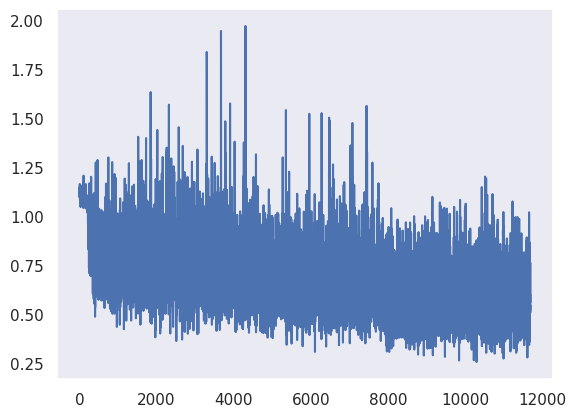

In [52]:
plt.plot(train_losses)

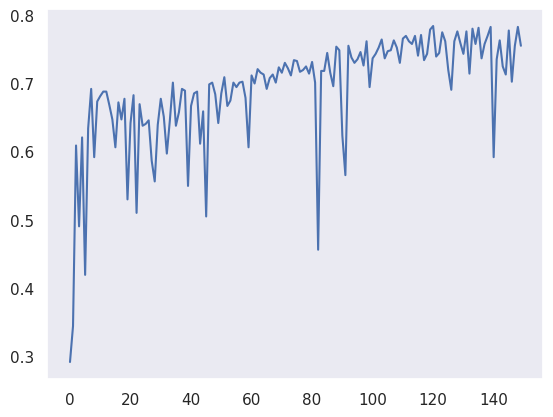

In [53]:
plt.plot(test_accuracy)

In [54]:
metrics4, confusion_matrix4 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics4.compute())
confusion_matrix4.compute()

Correct: 573/736 (0.7785)
{'acc_detail': tensor([0.8161, 0.7285, 0.7835], device='cuda:0'),
 'acc_unweighted': tensor(0.7760, device='cuda:0'),
 'acc_weighted': tensor(0.7785, device='cuda:0'),
 'f1s': tensor(0.7787, device='cuda:0'),
 'f1s_detail': tensor([0.8875, 0.6667, 0.7819], device='cuda:0'),
 'precision_detail': tensor([0.9726, 0.6145, 0.7804], device='cuda:0'),
 'recall_detail': tensor([0.8161, 0.7285, 0.7835], device='cuda:0'),
 'rocauc': tensor([0.9824, 0.8696, 0.9279], device='cuda:0'),
 'uar': tensor(0.7760, device='cuda:0'),
 'wap': tensor(0.7987, device='cuda:0')}


tensor([[213,  48,   0],
        [  4, 161,  56],
        [  2,  53, 199]], device='cuda:0')

In [55]:
np.save('../cremad3_m12new_150epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_m12new_150epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [56]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [57]:
best_epoch = 121
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 596/736 (0.8098)
{'acc_detail': tensor([0.9186, 0.7376, 0.7626], device='cuda:0'),
 'acc_unweighted': tensor(0.8063, device='cuda:0'),
 'acc_weighted': tensor(0.8098, device='cuda:0'),
 'f1s': tensor(0.8055, device='cuda:0'),
 'f1s_detail': tensor([0.9063, 0.7102, 0.8000], device='cuda:0'),
 'precision_detail': tensor([0.8943, 0.6849, 0.8412], device='cuda:0'),
 'recall_detail': tensor([0.9186, 0.7376, 0.7626], device='cuda:0'),
 'rocauc': tensor([0.9794, 0.8740, 0.9258], device='cuda:0'),
 'uar': tensor(0.8063, device='cuda:0'),
 'wap': tensor(0.8129, device='cuda:0')}


tensor([[237,  21,   0],
        [ 21, 163,  37],
        [  7,  54, 196]], device='cuda:0')

In [58]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [59]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
n_epoch5 = 200
# train_losses = []
# test_accuracy = []
# best_accuracy = max(test_accuracy)
model_path_prefix = '../models_cremad3/cremad_label3_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch5)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch5) as pbar:
    for epoch in range(1+150, n_epoch5+150 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.019801980198019802/200 [00:00<1:06:20, 19.90s/it]

Train Epoch: 151 [0/2508 (0%)]	Loss: 0.636784
Mem before-during-after: 25006592 112907264 26017280


  0%|▎                                                                                                                                                                           | 0.41584158415841604/200 [00:08<1:03:51, 19.20s/it]

Train Epoch: 151 [1280/2508 (51%)]	Loss: 0.807599
Mem before-during-after: 26017280 113959424 26017280


  1%|▊                                                                                                                                                                            | 1.0099009900990106/200 [00:19<1:03:24, 19.12s/it]


Test Epoch: 151	Accuracy: 591/736 (78%)

Train Epoch: 152 [0/2508 (0%)]	Loss: 0.489771
Mem before-during-after: 26013184 113959424 26017280


  1%|█▏                                                                                                                                                                           | 1.4158415841584169/200 [00:27<1:04:05, 19.36s/it]

Train Epoch: 152 [1280/2508 (51%)]	Loss: 0.537895
Mem before-during-after: 26017280 113959424 26017280


  1%|█▋                                                                                                                                                                           | 2.0099009900990112/200 [00:38<1:02:34, 18.97s/it]


Test Epoch: 152	Accuracy: 591/736 (78%)

Train Epoch: 153 [0/2508 (0%)]	Loss: 0.609196
Mem before-during-after: 26013184 113959424 26017280


  1%|██                                                                                                                                                                           | 2.4158415841584175/200 [00:46<1:03:39, 19.33s/it]

Train Epoch: 153 [1280/2508 (51%)]	Loss: 0.577257
Mem before-during-after: 26017280 113959424 26017280


  2%|██▌                                                                                                                                                                           | 3.009900990099012/200 [00:58<1:02:50, 19.14s/it]


Test Epoch: 153	Accuracy: 594/736 (78%)

Train Epoch: 154 [0/2508 (0%)]	Loss: 0.837878
Mem before-during-after: 26013184 113959424 26017280


  2%|██▉                                                                                                                                                                          | 3.4158415841584184/200 [01:06<1:04:34, 19.71s/it]

Train Epoch: 154 [1280/2508 (51%)]	Loss: 0.524418
Mem before-during-after: 26017280 113959424 26017280


  2%|███▍                                                                                                                                                                          | 4.009900990099013/200 [01:17<1:02:23, 19.10s/it]


Test Epoch: 154	Accuracy: 548/736 (72%)

Train Epoch: 155 [0/2508 (0%)]	Loss: 0.540950
Mem before-during-after: 26013184 113959424 26017280


  2%|███▊                                                                                                                                                                          | 4.415841584158419/200 [01:25<1:03:12, 19.39s/it]

Train Epoch: 155 [1280/2508 (51%)]	Loss: 0.752632
Mem before-during-after: 26017280 113959424 26017280


  3%|████▎                                                                                                                                                                        | 5.0099009900990135/200 [01:37<1:02:04, 19.10s/it]


Test Epoch: 155	Accuracy: 581/736 (77%)

Train Epoch: 156 [0/2508 (0%)]	Loss: 0.662718
Mem before-during-after: 26013184 113959424 26017280


  3%|████▋                                                                                                                                                                          | 5.41584158415842/200 [01:45<1:03:12, 19.49s/it]

Train Epoch: 156 [1280/2508 (51%)]	Loss: 0.592645
Mem before-during-after: 26017280 113959424 26017280


  3%|█████▏                                                                                                                                                                        | 6.009900990099014/200 [01:56<1:01:42, 19.09s/it]


Test Epoch: 156	Accuracy: 591/736 (78%)

Train Epoch: 157 [0/2508 (0%)]	Loss: 0.662396
Mem before-during-after: 26013184 113959424 26017280


  3%|█████▌                                                                                                                                                                        | 6.415841584158421/200 [02:04<1:03:13, 19.60s/it]

Train Epoch: 157 [1280/2508 (51%)]	Loss: 0.651856
Mem before-during-after: 26017280 113959424 26017280


  4%|██████                                                                                                                                                                        | 7.009900990099015/200 [02:16<1:02:01, 19.28s/it]


Test Epoch: 157	Accuracy: 561/736 (74%)

Train Epoch: 158 [0/2508 (0%)]	Loss: 0.504457
Mem before-during-after: 26013184 113959424 26017280


  4%|██████▍                                                                                                                                                                      | 7.4158415841584215/200 [02:24<1:02:46, 19.56s/it]

Train Epoch: 158 [1280/2508 (51%)]	Loss: 0.524753
Mem before-during-after: 26017280 113959424 26017280


  4%|██████▉                                                                                                                                                                       | 8.009900990099014/200 [02:35<1:01:17, 19.16s/it]


Test Epoch: 158	Accuracy: 566/736 (75%)

Train Epoch: 159 [0/2508 (0%)]	Loss: 0.585112
Mem before-during-after: 26013184 113959424 26017280


  4%|███████▎                                                                                                                                                                      | 8.415841584158384/200 [02:43<1:02:42, 19.64s/it]

Train Epoch: 159 [1280/2508 (51%)]	Loss: 0.413933
Mem before-during-after: 26017280 113959424 26017280


  5%|███████▊                                                                                                                                                                      | 9.009900990098926/200 [02:55<1:01:17, 19.25s/it]


Test Epoch: 159	Accuracy: 548/736 (72%)

Train Epoch: 160 [0/2508 (0%)]	Loss: 0.435591
Mem before-during-after: 26013184 113959424 26017280


  5%|████████▏                                                                                                                                                                     | 9.415841584158295/200 [03:03<1:01:58, 19.51s/it]

Train Epoch: 160 [1280/2508 (51%)]	Loss: 0.576905
Mem before-during-after: 26017280 113959424 26017280


  5%|████████▋                                                                                                                                                                    | 10.009900990098837/200 [03:14<1:01:00, 19.27s/it]


Test Epoch: 160	Accuracy: 594/736 (78%)

Train Epoch: 161 [0/2508 (0%)]	Loss: 0.466950
Mem before-during-after: 26013184 113959424 26017280


  5%|█████████                                                                                                                                                                    | 10.415841584158207/200 [03:22<1:01:25, 19.44s/it]

Train Epoch: 161 [1280/2508 (51%)]	Loss: 0.372707
Mem before-during-after: 26017280 113959424 26017280


  6%|█████████▌                                                                                                                                                                   | 11.009900990098748/200 [03:34<1:00:57, 19.35s/it]


Test Epoch: 161	Accuracy: 593/736 (78%)

Train Epoch: 162 [0/2508 (0%)]	Loss: 0.395752
Mem before-during-after: 26013184 113959424 26017280


  6%|█████████▊                                                                                                                                                                   | 11.415841584158118/200 [03:42<1:02:24, 19.86s/it]

Train Epoch: 162 [1280/2508 (51%)]	Loss: 0.369044
Mem before-during-after: 26017280 113959424 26017280


  6%|██████████▍                                                                                                                                                                  | 12.009900990098659/200 [03:54<1:00:35, 19.34s/it]


Test Epoch: 162	Accuracy: 589/736 (78%)

Train Epoch: 163 [0/2508 (0%)]	Loss: 0.429667
Mem before-during-after: 26013184 113959424 26017280


  6%|██████████▋                                                                                                                                                                  | 12.415841584158029/200 [04:02<1:00:55, 19.48s/it]

Train Epoch: 163 [1280/2508 (51%)]	Loss: 0.335892
Mem before-during-after: 26017280 113959424 26017280


  7%|███████████▍                                                                                                                                                                    | 13.00990099009857/200 [04:13<59:48, 19.19s/it]


Test Epoch: 163	Accuracy: 586/736 (77%)

Train Epoch: 164 [0/2508 (0%)]	Loss: 0.620495
Mem before-during-after: 26013184 113959424 26017280


  7%|███████████▋                                                                                                                                                                  | 13.41584158415794/200 [04:21<1:00:18, 19.39s/it]

Train Epoch: 164 [1280/2508 (51%)]	Loss: 0.562292
Mem before-during-after: 26017280 113959424 26017280


  7%|████████████▎                                                                                                                                                                  | 14.009900990098481/200 [04:33<59:42, 19.26s/it]


Test Epoch: 164	Accuracy: 542/736 (71%)

Train Epoch: 165 [0/2508 (0%)]	Loss: 0.514590
Mem before-during-after: 26013184 113959424 26017280


  7%|████████████▍                                                                                                                                                                | 14.415841584157851/200 [04:41<1:00:38, 19.61s/it]

Train Epoch: 165 [1280/2508 (51%)]	Loss: 0.410697
Mem before-during-after: 26017280 113959424 26017280


  8%|█████████████▏                                                                                                                                                                 | 15.009900990098393/200 [04:52<58:15, 18.89s/it]


Test Epoch: 165	Accuracy: 571/736 (75%)

Train Epoch: 166 [0/2508 (0%)]	Loss: 0.527940
Mem before-during-after: 26013184 113959424 26017280


  8%|█████████████▎                                                                                                                                                               | 15.415841584157763/200 [05:00<1:00:26, 19.65s/it]

Train Epoch: 166 [1280/2508 (51%)]	Loss: 0.350530
Mem before-during-after: 26017280 113959424 26017280


  8%|██████████████                                                                                                                                                                 | 16.009900990098306/200 [05:11<58:56, 19.22s/it]


Test Epoch: 166	Accuracy: 598/736 (79%)

saved model: ../models_cremad3/cremad_label3_m12new_best_166epoch.pt
Train Epoch: 167 [0/2508 (0%)]	Loss: 0.561563
Mem before-during-after: 26013184 113959424 26017280


  8%|██████████████▎                                                                                                                                                                | 16.415841584157675/200 [05:19<59:31, 19.46s/it]

Train Epoch: 167 [1280/2508 (51%)]	Loss: 0.617036
Mem before-during-after: 26017280 113959424 26017280


  9%|██████████████▉                                                                                                                                                                | 17.009900990098217/200 [05:31<58:16, 19.11s/it]


Test Epoch: 167	Accuracy: 573/736 (75%)

Train Epoch: 168 [0/2508 (0%)]	Loss: 0.694054
Mem before-during-after: 26013184 113959424 26017280


  9%|███████████████▏                                                                                                                                                               | 17.415841584157587/200 [05:39<58:47, 19.32s/it]

Train Epoch: 168 [1280/2508 (51%)]	Loss: 0.668526
Mem before-during-after: 26017280 113959424 26017280


  9%|███████████████▊                                                                                                                                                               | 18.009900990098128/200 [05:50<57:26, 18.94s/it]


Test Epoch: 168	Accuracy: 590/736 (78%)

Train Epoch: 169 [0/2508 (0%)]	Loss: 0.414059
Mem before-during-after: 26013184 113959424 26017280


  9%|████████████████                                                                                                                                                               | 18.415841584157498/200 [05:58<58:21, 19.29s/it]

Train Epoch: 169 [1280/2508 (51%)]	Loss: 0.417761
Mem before-during-after: 26017280 113959424 26017280


 10%|████████████████▋                                                                                                                                                               | 19.00990099009804/200 [06:09<57:13, 18.97s/it]


Test Epoch: 169	Accuracy: 553/736 (73%)

Train Epoch: 170 [0/2508 (0%)]	Loss: 0.756405
Mem before-during-after: 26013184 113959424 26017280


 10%|█████████████████                                                                                                                                                               | 19.41584158415741/200 [06:17<57:57, 19.26s/it]

Train Epoch: 170 [1280/2508 (51%)]	Loss: 0.521086
Mem before-during-after: 26017280 113959424 26017280


 10%|█████████████████▌                                                                                                                                                              | 20.00990099009795/200 [06:29<57:02, 19.01s/it]


Test Epoch: 170	Accuracy: 594/736 (78%)

Train Epoch: 171 [0/2508 (0%)]	Loss: 0.587895
Mem before-during-after: 26013184 113959424 26017280


 10%|█████████████████▉                                                                                                                                                              | 20.41584158415732/200 [06:36<57:43, 19.29s/it]

Train Epoch: 171 [1280/2508 (51%)]	Loss: 0.431562
Mem before-during-after: 26017280 113959424 26017280


 11%|██████████████████▍                                                                                                                                                             | 21.00990099009786/200 [06:48<56:22, 18.90s/it]


Test Epoch: 171	Accuracy: 594/736 (78%)

Train Epoch: 172 [0/2508 (0%)]	Loss: 0.406183
Mem before-during-after: 26013184 113959424 26017280


 11%|██████████████████▊                                                                                                                                                             | 21.41584158415723/200 [06:56<57:23, 19.28s/it]

Train Epoch: 172 [1280/2508 (51%)]	Loss: 0.600138
Mem before-during-after: 26017280 113959424 26017280


 11%|███████████████████▎                                                                                                                                                           | 22.009900990097773/200 [07:07<56:14, 18.96s/it]


Test Epoch: 172	Accuracy: 569/736 (75%)

Train Epoch: 173 [0/2508 (0%)]	Loss: 0.452831
Mem before-during-after: 26013184 113959424 26017280


 11%|███████████████████▌                                                                                                                                                           | 22.415841584157143/200 [07:15<57:17, 19.36s/it]

Train Epoch: 173 [1280/2508 (51%)]	Loss: 0.530520
Mem before-during-after: 26017280 113959424 26017280


 12%|████████████████████▏                                                                                                                                                          | 23.009900990097684/200 [07:26<55:54, 18.95s/it]


Test Epoch: 173	Accuracy: 573/736 (75%)

Train Epoch: 174 [0/2508 (0%)]	Loss: 0.792775
Mem before-during-after: 26013184 113959424 26017280


 12%|████████████████████▎                                                                                                                                                        | 23.415841584157054/200 [07:34<1:01:50, 21.01s/it]

Train Epoch: 174 [1280/2508 (51%)]	Loss: 0.496160
Mem before-during-after: 26017280 113959424 26017280


 12%|█████████████████████                                                                                                                                                          | 24.009900990097595/200 [07:46<56:03, 19.11s/it]


Test Epoch: 174	Accuracy: 572/736 (75%)

Train Epoch: 175 [0/2508 (0%)]	Loss: 0.335173
Mem before-during-after: 26013184 113959424 26017280


 12%|█████████████████████▎                                                                                                                                                         | 24.415841584156965/200 [07:54<57:12, 19.55s/it]

Train Epoch: 175 [1280/2508 (51%)]	Loss: 0.646721
Mem before-during-after: 26017280 113959424 26017280


 13%|█████████████████████▉                                                                                                                                                         | 25.009900990097506/200 [08:05<55:23, 18.99s/it]


Test Epoch: 175	Accuracy: 544/736 (72%)

Train Epoch: 176 [0/2508 (0%)]	Loss: 0.688421
Mem before-during-after: 26013184 113959424 26017280


 13%|██████████████████████▏                                                                                                                                                        | 25.415841584156876/200 [08:13<57:11, 19.65s/it]

Train Epoch: 176 [1280/2508 (51%)]	Loss: 0.308989
Mem before-during-after: 26017280 113959424 26017280


 13%|██████████████████████▊                                                                                                                                                        | 26.009900990097417/200 [08:25<56:31, 19.49s/it]


Test Epoch: 176	Accuracy: 546/736 (72%)

Train Epoch: 177 [0/2508 (0%)]	Loss: 0.536516
Mem before-during-after: 26013184 113959424 26017280


 13%|███████████████████████                                                                                                                                                        | 26.415841584156787/200 [08:33<57:19, 19.81s/it]

Train Epoch: 177 [1280/2508 (51%)]	Loss: 0.570214
Mem before-during-after: 26017280 113959424 26017280


 14%|███████████████████████▊                                                                                                                                                        | 27.00990099009733/200 [08:44<55:54, 19.39s/it]


Test Epoch: 177	Accuracy: 580/736 (76%)

Train Epoch: 178 [0/2508 (0%)]	Loss: 0.455419
Mem before-during-after: 26013184 113959424 26017280


 14%|████████████████████████▎                                                                                                                                                        | 27.4158415841567/200 [08:52<56:45, 19.73s/it]

Train Epoch: 178 [1280/2508 (51%)]	Loss: 0.558798
Mem before-during-after: 26017280 113959424 26017280


 14%|████████████████████████▋                                                                                                                                                       | 28.00990099009724/200 [09:04<54:35, 19.04s/it]


Test Epoch: 178	Accuracy: 581/736 (77%)

Train Epoch: 179 [0/2508 (0%)]	Loss: 0.649041
Mem before-during-after: 26013184 113959424 26017280


 14%|█████████████████████████                                                                                                                                                       | 28.41584158415661/200 [09:12<55:09, 19.29s/it]

Train Epoch: 179 [1280/2508 (51%)]	Loss: 0.792573
Mem before-during-after: 26017280 113959424 26017280


 15%|█████████████████████████▌                                                                                                                                                      | 29.00990099009715/200 [09:23<53:56, 18.93s/it]


Test Epoch: 179	Accuracy: 544/736 (72%)

Train Epoch: 180 [0/2508 (0%)]	Loss: 0.483011
Mem before-during-after: 26013184 113959424 26017280


 15%|█████████████████████████▉                                                                                                                                                      | 29.41584158415652/200 [09:31<54:44, 19.26s/it]

Train Epoch: 180 [1280/2508 (51%)]	Loss: 0.668185
Mem before-during-after: 26017280 113959424 26017280


 15%|██████████████████████████▎                                                                                                                                                    | 30.009900990097062/200 [09:42<53:44, 18.97s/it]


Test Epoch: 180	Accuracy: 559/736 (74%)

Train Epoch: 181 [0/2508 (0%)]	Loss: 0.665770
Mem before-during-after: 26013184 113959424 26017280


 15%|██████████████████████████▌                                                                                                                                                    | 30.415841584156432/200 [09:50<54:40, 19.34s/it]

Train Epoch: 181 [1280/2508 (51%)]	Loss: 0.375906
Mem before-during-after: 26017280 113959424 26017280


 16%|███████████████████████████▏                                                                                                                                                   | 31.009900990096973/200 [10:01<53:25, 18.97s/it]


Test Epoch: 181	Accuracy: 584/736 (77%)

Train Epoch: 182 [0/2508 (0%)]	Loss: 0.627168
Mem before-during-after: 26013184 113959424 26017280


 16%|███████████████████████████▍                                                                                                                                                   | 31.415841584156343/200 [10:09<54:15, 19.31s/it]

Train Epoch: 182 [1280/2508 (51%)]	Loss: 0.348836
Mem before-during-after: 26017280 113959424 26017280


 16%|████████████████████████████▏                                                                                                                                                   | 32.00990099009689/200 [10:20<53:07, 18.98s/it]


Test Epoch: 182	Accuracy: 581/736 (77%)

Train Epoch: 183 [0/2508 (0%)]	Loss: 0.629379
Mem before-during-after: 26013184 113959424 26017280


 16%|████████████████████████████▎                                                                                                                                                  | 32.415841584156404/200 [10:28<54:11, 19.40s/it]

Train Epoch: 183 [1280/2508 (51%)]	Loss: 0.616978
Mem before-during-after: 26017280 113959424 26017280


 17%|█████████████████████████████                                                                                                                                                   | 33.00990099009716/200 [10:40<52:43, 18.94s/it]


Test Epoch: 183	Accuracy: 573/736 (75%)

Train Epoch: 184 [0/2508 (0%)]	Loss: 0.391526
Mem before-during-after: 26013184 113959424 26017280


 17%|█████████████████████████████▏                                                                                                                                                 | 33.415841584156674/200 [10:48<53:29, 19.27s/it]

Train Epoch: 184 [1280/2508 (51%)]	Loss: 0.441922
Mem before-during-after: 26017280 113959424 26017280


 17%|█████████████████████████████▉                                                                                                                                                  | 34.00990099009743/200 [10:59<53:04, 19.19s/it]


Test Epoch: 184	Accuracy: 590/736 (78%)

Train Epoch: 185 [0/2508 (0%)]	Loss: 0.820510
Mem before-during-after: 26013184 113959424 26017280


 17%|██████████████████████████████                                                                                                                                                 | 34.415841584156944/200 [11:07<52:59, 19.20s/it]

Train Epoch: 185 [1280/2508 (51%)]	Loss: 0.758634
Mem before-during-after: 26017280 113959424 26017280


 18%|██████████████████████████████▉                                                                                                                                                  | 35.0099009900977/200 [11:18<52:01, 18.92s/it]


Test Epoch: 185	Accuracy: 585/736 (77%)

Train Epoch: 186 [0/2508 (0%)]	Loss: 0.555309
Mem before-during-after: 26013184 113959424 26017280


 18%|██████████████████████████████▉                                                                                                                                                | 35.415841584157214/200 [11:26<52:47, 19.25s/it]

Train Epoch: 186 [1280/2508 (51%)]	Loss: 0.759352
Mem before-during-after: 26017280 113959424 26017280


 18%|███████████████████████████████▋                                                                                                                                                | 36.00990099009797/200 [11:37<51:57, 19.01s/it]


Test Epoch: 186	Accuracy: 590/736 (78%)

Train Epoch: 187 [0/2508 (0%)]	Loss: 0.380178
Mem before-during-after: 26013184 113959424 26017280


 18%|███████████████████████████████▊                                                                                                                                               | 36.415841584157484/200 [11:45<52:27, 19.24s/it]

Train Epoch: 187 [1280/2508 (51%)]	Loss: 0.376344
Mem before-during-after: 26017280 113959424 26017280


 19%|████████████████████████████████▌                                                                                                                                               | 37.00990099009824/200 [11:57<51:55, 19.11s/it]


Test Epoch: 187	Accuracy: 584/736 (77%)

Train Epoch: 188 [0/2508 (0%)]	Loss: 0.816836
Mem before-during-after: 26013184 113959424 26017280


 19%|████████████████████████████████▋                                                                                                                                              | 37.415841584157754/200 [12:05<52:36, 19.42s/it]

Train Epoch: 188 [1280/2508 (51%)]	Loss: 0.618064
Mem before-during-after: 26017280 113959424 26017280


 19%|█████████████████████████████████▍                                                                                                                                              | 38.00990099009851/200 [12:16<51:59, 19.26s/it]


Test Epoch: 188	Accuracy: 577/736 (76%)

Train Epoch: 189 [0/2508 (0%)]	Loss: 0.528192
Mem before-during-after: 26013184 113959424 26017280


 19%|█████████████████████████████████▌                                                                                                                                             | 38.415841584158024/200 [12:24<52:46, 19.59s/it]

Train Epoch: 189 [1280/2508 (51%)]	Loss: 0.679452
Mem before-during-after: 26017280 113959424 26017280


 20%|██████████████████████████████████▎                                                                                                                                             | 39.00990099009878/200 [12:36<52:03, 19.40s/it]


Test Epoch: 189	Accuracy: 573/736 (75%)

Train Epoch: 190 [0/2508 (0%)]	Loss: 0.405756
Mem before-during-after: 26013184 113959424 26017280


 20%|██████████████████████████████████▍                                                                                                                                            | 39.415841584158294/200 [12:44<52:13, 19.51s/it]

Train Epoch: 190 [1280/2508 (51%)]	Loss: 0.789607
Mem before-during-after: 26017280 113959424 26017280


 20%|███████████████████████████████████▏                                                                                                                                            | 40.00990099009905/200 [12:55<51:06, 19.17s/it]


Test Epoch: 190	Accuracy: 552/736 (73%)

Train Epoch: 191 [0/2508 (0%)]	Loss: 0.595827
Mem before-during-after: 26013184 113959424 26017280


 20%|███████████████████████████████████▌                                                                                                                                            | 40.40594059405955/200 [13:03<51:35, 19.40s/it]

Train Epoch: 191 [1280/2508 (51%)]	Loss: 0.471889
Mem before-during-after: 26017280 113959424 26017280


 21%|████████████████████████████████████                                                                                                                                            | 41.00990099009932/200 [13:15<50:33, 19.08s/it]


Test Epoch: 191	Accuracy: 589/736 (78%)

Train Epoch: 192 [0/2508 (0%)]	Loss: 0.560760
Mem before-during-after: 26013184 113959424 26017280


 21%|████████████████████████████████████▏                                                                                                                                          | 41.415841584158834/200 [13:23<51:19, 19.42s/it]

Train Epoch: 192 [1280/2508 (51%)]	Loss: 0.500474
Mem before-during-after: 26017280 113959424 26017280


 21%|████████████████████████████████████▉                                                                                                                                           | 42.00990099009959/200 [13:34<51:00, 19.37s/it]


Test Epoch: 192	Accuracy: 541/736 (71%)

Train Epoch: 193 [0/2508 (0%)]	Loss: 0.633282
Mem before-during-after: 26013184 113959424 26017280


 21%|█████████████████████████████████████                                                                                                                                          | 42.415841584159104/200 [13:42<51:09, 19.48s/it]

Train Epoch: 193 [1280/2508 (51%)]	Loss: 0.562120
Mem before-during-after: 26017280 113959424 26017280


 22%|█████████████████████████████████████▊                                                                                                                                          | 43.00990099009986/200 [13:54<50:39, 19.36s/it]


Test Epoch: 193	Accuracy: 588/736 (77%)

Train Epoch: 194 [0/2508 (0%)]	Loss: 0.241170
Mem before-during-after: 26013184 113959424 26017280


 22%|█████████████████████████████████████▉                                                                                                                                         | 43.415841584159374/200 [14:02<52:31, 20.12s/it]

Train Epoch: 194 [1280/2508 (51%)]	Loss: 0.655171
Mem before-during-after: 26017280 113959424 26017280


 22%|██████████████████████████████████████▋                                                                                                                                         | 44.00990099010013/200 [14:13<50:00, 19.23s/it]


Test Epoch: 194	Accuracy: 574/736 (76%)

Train Epoch: 195 [0/2508 (0%)]	Loss: 0.799574
Mem before-during-after: 26013184 113959424 26017280


 22%|██████████████████████████████████████▊                                                                                                                                        | 44.415841584159644/200 [14:21<50:05, 19.32s/it]

Train Epoch: 195 [1280/2508 (51%)]	Loss: 1.260954
Mem before-during-after: 26017280 113959424 26017280


 23%|███████████████████████████████████████▊                                                                                                                                         | 45.0099009901004/200 [14:32<48:51, 18.92s/it]


Test Epoch: 195	Accuracy: 591/736 (78%)

Train Epoch: 196 [0/2508 (0%)]	Loss: 0.476035
Mem before-during-after: 26013184 113959424 26017280


 23%|███████████████████████████████████████▋                                                                                                                                       | 45.415841584159914/200 [14:40<49:57, 19.39s/it]

Train Epoch: 196 [1280/2508 (51%)]	Loss: 0.625270
Mem before-during-after: 26017280 113959424 26017280


 23%|████████████████████████████████████████▍                                                                                                                                       | 46.00990099010067/200 [14:52<49:04, 19.12s/it]


Test Epoch: 196	Accuracy: 589/736 (78%)

Train Epoch: 197 [0/2508 (0%)]	Loss: 0.699302
Mem before-during-after: 26013184 113959424 26017280


 23%|████████████████████████████████████████▌                                                                                                                                      | 46.415841584160184/200 [15:00<50:06, 19.58s/it]

Train Epoch: 197 [1280/2508 (51%)]	Loss: 0.595938
Mem before-during-after: 26017280 113959424 26017280


 24%|█████████████████████████████████████████▎                                                                                                                                      | 47.00990099010094/200 [15:11<49:06, 19.26s/it]


Test Epoch: 197	Accuracy: 586/736 (77%)

Train Epoch: 198 [0/2508 (0%)]	Loss: 0.434666
Mem before-during-after: 26013184 113959424 26017280


 24%|█████████████████████████████████████████▍                                                                                                                                     | 47.415841584160454/200 [15:19<48:59, 19.27s/it]

Train Epoch: 198 [1280/2508 (51%)]	Loss: 0.490132
Mem before-during-after: 26017280 113959424 26017280


 24%|██████████████████████████████████████████▏                                                                                                                                     | 48.00990099010121/200 [15:31<48:54, 19.31s/it]


Test Epoch: 198	Accuracy: 581/736 (77%)

Train Epoch: 199 [0/2508 (0%)]	Loss: 0.566054
Mem before-during-after: 26013184 113959424 26017280


 24%|██████████████████████████████████████████▎                                                                                                                                    | 48.415841584160724/200 [15:39<50:10, 19.86s/it]

Train Epoch: 199 [1280/2508 (51%)]	Loss: 0.404010
Mem before-during-after: 26017280 113959424 26017280


 25%|███████████████████████████████████████████▏                                                                                                                                    | 49.00990099010148/200 [15:50<47:47, 18.99s/it]


Test Epoch: 199	Accuracy: 588/736 (77%)

Train Epoch: 200 [0/2508 (0%)]	Loss: 0.792480
Mem before-during-after: 26013184 113959424 26017280


 25%|███████████████████████████████████████████▏                                                                                                                                   | 49.415841584160994/200 [15:58<48:27, 19.31s/it]

Train Epoch: 200 [1280/2508 (51%)]	Loss: 0.445834
Mem before-during-after: 26017280 113959424 26017280


 25%|████████████████████████████████████████████                                                                                                                                    | 50.00990099010175/200 [16:09<48:24, 19.36s/it]


Test Epoch: 200	Accuracy: 583/736 (77%)

Train Epoch: 201 [0/2508 (0%)]	Loss: 0.746200
Mem before-during-after: 26013184 113959424 26017280


 25%|████████████████████████████████████████████                                                                                                                                   | 50.415841584161264/200 [16:17<48:35, 19.49s/it]

Train Epoch: 201 [1280/2508 (51%)]	Loss: 0.499979
Mem before-during-after: 26017280 113959424 26017280


 26%|████████████████████████████████████████████▉                                                                                                                                   | 51.00990099010202/200 [16:29<47:28, 19.12s/it]


Test Epoch: 201	Accuracy: 530/736 (70%)

Train Epoch: 202 [0/2508 (0%)]	Loss: 0.597213
Mem before-during-after: 26013184 113959424 26017280


 26%|████████████████████████████████████████████▉                                                                                                                                  | 51.415841584161534/200 [16:37<48:03, 19.41s/it]

Train Epoch: 202 [1280/2508 (51%)]	Loss: 0.799506
Mem before-during-after: 26017280 113959424 26017280


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 52.00990099010229/200 [16:48<47:56, 19.44s/it]


Test Epoch: 202	Accuracy: 550/736 (72%)

Train Epoch: 203 [0/2508 (0%)]	Loss: 0.663368
Mem before-during-after: 26013184 113959424 26017280


 26%|█████████████████████████████████████████████▊                                                                                                                                 | 52.415841584161804/200 [16:56<48:16, 19.63s/it]

Train Epoch: 203 [1280/2508 (51%)]	Loss: 0.900112
Mem before-during-after: 26017280 113959424 26017280


 27%|██████████████████████████████████████████████▋                                                                                                                                 | 53.00990099010256/200 [17:08<47:35, 19.42s/it]


Test Epoch: 203	Accuracy: 505/736 (67%)

Train Epoch: 204 [0/2508 (0%)]	Loss: 0.988148
Mem before-during-after: 26013184 113959424 26017280


 27%|██████████████████████████████████████████████▋                                                                                                                                | 53.415841584162074/200 [17:16<47:35, 19.48s/it]

Train Epoch: 204 [1280/2508 (51%)]	Loss: 0.373774
Mem before-during-after: 26017280 113959424 26017280


 27%|███████████████████████████████████████████████▌                                                                                                                                | 54.00990099010283/200 [17:27<46:54, 19.28s/it]


Test Epoch: 204	Accuracy: 577/736 (76%)

Train Epoch: 205 [0/2508 (0%)]	Loss: 0.393498
Mem before-during-after: 26013184 113959424 26017280


 27%|███████████████████████████████████████████████▉                                                                                                                                | 54.40594059406333/200 [17:35<47:43, 19.67s/it]

Train Epoch: 205 [1280/2508 (51%)]	Loss: 0.519503
Mem before-during-after: 26017280 113959424 26017280


 28%|████████████████████████████████████████████████▋                                                                                                                                | 55.0099009901031/200 [17:47<46:35, 19.28s/it]


Test Epoch: 205	Accuracy: 588/736 (77%)

Train Epoch: 206 [0/2508 (0%)]	Loss: 0.394638
Mem before-during-after: 26013184 113959424 26017280


 28%|████████████████████████████████████████████████▍                                                                                                                              | 55.415841584162614/200 [17:55<47:34, 19.74s/it]

Train Epoch: 206 [1280/2508 (51%)]	Loss: 0.444513
Mem before-during-after: 26017280 113959424 26017280


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 56.00990099010337/200 [18:07<46:33, 19.40s/it]


Test Epoch: 206	Accuracy: 552/736 (73%)

Train Epoch: 207 [0/2508 (0%)]	Loss: 0.536786
Mem before-during-after: 26013184 113959424 26017280


 28%|█████████████████████████████████████████████████▎                                                                                                                             | 56.415841584162884/200 [18:15<47:08, 19.70s/it]

Train Epoch: 207 [1280/2508 (51%)]	Loss: 0.658956
Mem before-during-after: 26017280 113959424 26017280


 29%|██████████████████████████████████████████████████▏                                                                                                                             | 57.00990099010364/200 [18:26<45:56, 19.28s/it]


Test Epoch: 207	Accuracy: 576/736 (76%)

Train Epoch: 208 [0/2508 (0%)]	Loss: 0.641737
Mem before-during-after: 26013184 113959424 26017280


 29%|██████████████████████████████████████████████████▏                                                                                                                            | 57.415841584163154/200 [18:34<47:03, 19.80s/it]

Train Epoch: 208 [1280/2508 (51%)]	Loss: 0.585646
Mem before-during-after: 26017280 113959424 26017280


 29%|███████████████████████████████████████████████████                                                                                                                             | 58.00990099010391/200 [18:46<45:54, 19.40s/it]


Test Epoch: 208	Accuracy: 582/736 (77%)

Train Epoch: 209 [0/2508 (0%)]	Loss: 0.749986
Mem before-during-after: 26013184 113959424 26017280


 29%|███████████████████████████████████████████████████                                                                                                                            | 58.415841584163424/200 [18:54<46:39, 19.77s/it]

Train Epoch: 209 [1280/2508 (51%)]	Loss: 1.076996
Mem before-during-after: 26017280 113959424 26017280


 30%|███████████████████████████████████████████████████▉                                                                                                                            | 59.00990099010418/200 [19:06<44:38, 19.00s/it]


Test Epoch: 209	Accuracy: 545/736 (72%)

Train Epoch: 210 [0/2508 (0%)]	Loss: 0.753840
Mem before-during-after: 26013184 113959424 26017280


 30%|███████████████████████████████████████████████████▉                                                                                                                           | 59.415841584163694/200 [19:14<45:27, 19.40s/it]

Train Epoch: 210 [1280/2508 (51%)]	Loss: 0.517459
Mem before-during-after: 26017280 113959424 26017280


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 60.00990099010445/200 [19:25<45:09, 19.36s/it]


Test Epoch: 210	Accuracy: 565/736 (74%)

Train Epoch: 211 [0/2508 (0%)]	Loss: 0.456700
Mem before-during-after: 26013184 113959424 26017280


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 60.415841584163964/200 [19:33<45:01, 19.36s/it]

Train Epoch: 211 [1280/2508 (51%)]	Loss: 0.349596
Mem before-during-after: 26017280 113959424 26017280


 31%|█████████████████████████████████████████████████████▋                                                                                                                          | 61.00990099010472/200 [19:44<43:57, 18.98s/it]


Test Epoch: 211	Accuracy: 553/736 (73%)

Train Epoch: 212 [0/2508 (0%)]	Loss: 0.577239
Mem before-during-after: 26013184 113959424 26017280


 31%|█████████████████████████████████████████████████████▋                                                                                                                         | 61.415841584164234/200 [19:52<44:26, 19.24s/it]

Train Epoch: 212 [1280/2508 (51%)]	Loss: 0.599690
Mem before-during-after: 26017280 113959424 26017280


 31%|██████████████████████████████████████████████████████▌                                                                                                                         | 62.00990099010499/200 [20:03<44:04, 19.17s/it]


Test Epoch: 212	Accuracy: 563/736 (74%)

Train Epoch: 213 [0/2508 (0%)]	Loss: 0.702199
Mem before-during-after: 26013184 113959424 26017280


 31%|██████████████████████████████████████████████████████▌                                                                                                                        | 62.415841584164504/200 [20:11<44:14, 19.29s/it]

Train Epoch: 213 [1280/2508 (51%)]	Loss: 0.633187
Mem before-during-after: 26017280 113959424 26017280


 32%|███████████████████████████████████████████████████████▍                                                                                                                        | 63.00990099010526/200 [20:23<43:15, 18.94s/it]


Test Epoch: 213	Accuracy: 588/736 (77%)

Train Epoch: 214 [0/2508 (0%)]	Loss: 0.679755
Mem before-during-after: 26013184 113959424 26017280


 32%|███████████████████████████████████████████████████████▍                                                                                                                       | 63.415841584164774/200 [20:31<43:56, 19.30s/it]

Train Epoch: 214 [1280/2508 (51%)]	Loss: 0.728094
Mem before-during-after: 26017280 113959424 26017280


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 64.00990099010552/200 [20:42<43:11, 19.06s/it]


Test Epoch: 214	Accuracy: 583/736 (77%)

Train Epoch: 215 [0/2508 (0%)]	Loss: 0.495127
Mem before-during-after: 26013184 113959424 26017280


 32%|████████████████████████████████████████████████████████▋                                                                                                                       | 64.41584158416504/200 [20:50<43:46, 19.37s/it]

Train Epoch: 215 [1280/2508 (51%)]	Loss: 0.523300
Mem before-during-after: 26017280 113959424 26017280


 33%|█████████████████████████████████████████████████████████▏                                                                                                                      | 65.00990099010579/200 [21:01<42:52, 19.06s/it]


Test Epoch: 215	Accuracy: 589/736 (78%)

Train Epoch: 216 [0/2508 (0%)]	Loss: 0.657892
Mem before-during-after: 26013184 113959424 26017280


 33%|█████████████████████████████████████████████████████████▉                                                                                                                       | 65.4158415841653/200 [21:09<43:27, 19.37s/it]

Train Epoch: 216 [1280/2508 (51%)]	Loss: 0.542943
Mem before-during-after: 26017280 113959424 26017280


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 66.00990099010606/200 [21:21<42:46, 19.16s/it]


Test Epoch: 216	Accuracy: 585/736 (77%)

Train Epoch: 217 [0/2508 (0%)]	Loss: 0.662219
Mem before-during-after: 26013184 113959424 26017280


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 66.41584158416558/200 [21:28<43:05, 19.35s/it]

Train Epoch: 217 [1280/2508 (51%)]	Loss: 0.401045
Mem before-during-after: 26017280 113959424 26017280


 34%|██████████████████████████████████████████████████████████▉                                                                                                                     | 67.00990099010633/200 [21:40<42:47, 19.31s/it]


Test Epoch: 217	Accuracy: 589/736 (78%)

Train Epoch: 218 [0/2508 (0%)]	Loss: 0.487217
Mem before-during-after: 26013184 113959424 26017280


 34%|███████████████████████████████████████████████████████████▎                                                                                                                    | 67.41584158416585/200 [21:48<43:21, 19.62s/it]

Train Epoch: 218 [1280/2508 (51%)]	Loss: 0.550566
Mem before-during-after: 26017280 113959424 26017280


 34%|████████████████████████████████████████████████████████████▏                                                                                                                    | 68.0099009901066/200 [22:00<42:55, 19.52s/it]


Test Epoch: 218	Accuracy: 574/736 (76%)

Train Epoch: 219 [0/2508 (0%)]	Loss: 0.467695
Mem before-during-after: 26013184 113959424 26017280


 34%|████████████████████████████████████████████████████████████▏                                                                                                                   | 68.41584158416612/200 [22:07<43:08, 19.68s/it]

Train Epoch: 219 [1280/2508 (51%)]	Loss: 0.504299
Mem before-during-after: 26017280 113959424 26017280


 35%|████████████████████████████████████████████████████████████▋                                                                                                                   | 69.00990099010687/200 [22:19<42:07, 19.29s/it]


Test Epoch: 219	Accuracy: 586/736 (77%)

Train Epoch: 220 [0/2508 (0%)]	Loss: 0.531019
Mem before-during-after: 26013184 113959424 26017280


 35%|█████████████████████████████████████████████████████████████                                                                                                                   | 69.41584158416639/200 [22:27<42:40, 19.61s/it]

Train Epoch: 220 [1280/2508 (51%)]	Loss: 0.585611
Mem before-during-after: 26017280 113959424 26017280


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 70.00990099010714/200 [22:39<41:54, 19.34s/it]


Test Epoch: 220	Accuracy: 576/736 (76%)

Train Epoch: 221 [0/2508 (0%)]	Loss: 0.364770
Mem before-during-after: 26013184 113959424 26017280


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 70.41584158416666/200 [22:47<42:29, 19.68s/it]

Train Epoch: 221 [1280/2508 (51%)]	Loss: 0.535536
Mem before-during-after: 26017280 113959424 26017280


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 71.0000000000084/200 [22:58<41:07, 19.13s/it]


Test Epoch: 221	Accuracy: 556/736 (73%)



 36%|██████████████████████████████████████████████████████████████▍                                                                                                                 | 71.00990099010741/200 [22:58<42:03, 19.56s/it]

Train Epoch: 222 [0/2508 (0%)]	Loss: 0.531660
Mem before-during-after: 26013184 113959424 26017280


 36%|██████████████████████████████████████████████████████████████▊                                                                                                                 | 71.41584158416693/200 [23:06<42:06, 19.65s/it]

Train Epoch: 222 [1280/2508 (51%)]	Loss: 0.427323
Mem before-during-after: 26017280 113959424 26017280


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 72.00990099010768/200 [23:18<41:11, 19.31s/it]


Test Epoch: 222	Accuracy: 592/736 (78%)

Train Epoch: 223 [0/2508 (0%)]	Loss: 0.393062
Mem before-during-after: 26013184 113959424 26017280


 36%|████████████████████████████████████████████████████████████████                                                                                                                 | 72.4158415841672/200 [23:26<42:00, 19.76s/it]

Train Epoch: 223 [1280/2508 (51%)]	Loss: 0.574041
Mem before-during-after: 26017280 113959424 26017280


 37%|████████████████████████████████████████████████████████████████▏                                                                                                               | 73.00990099010795/200 [23:38<40:21, 19.07s/it]


Test Epoch: 223	Accuracy: 583/736 (77%)

Train Epoch: 224 [0/2508 (0%)]	Loss: 0.504463
Mem before-during-after: 26013184 113959424 26017280


 37%|████████████████████████████████████████████████████████████████▌                                                                                                               | 73.41584158416747/200 [23:45<40:52, 19.38s/it]

Train Epoch: 224 [1280/2508 (51%)]	Loss: 0.531851
Mem before-during-after: 26017280 113959424 26017280


 37%|█████████████████████████████████████████████████████████████████▏                                                                                                              | 74.00990099010822/200 [23:57<39:42, 18.91s/it]


Test Epoch: 224	Accuracy: 592/736 (78%)

Train Epoch: 225 [0/2508 (0%)]	Loss: 0.583806
Mem before-during-after: 26013184 113959424 26017280


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 74.41584158416774/200 [24:05<41:13, 19.70s/it]

Train Epoch: 225 [1280/2508 (51%)]	Loss: 0.490019
Mem before-during-after: 26017280 113959424 26017280


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 75.00990099010849/200 [24:16<39:41, 19.05s/it]


Test Epoch: 225	Accuracy: 576/736 (76%)

Train Epoch: 226 [0/2508 (0%)]	Loss: 0.444308
Mem before-during-after: 26013184 113959424 26017280


 38%|███████████████████████████████████████████████████████████████████                                                                                                               | 75.415841584168/200 [24:24<40:24, 19.46s/it]

Train Epoch: 226 [1280/2508 (51%)]	Loss: 0.547011
Mem before-during-after: 26017280 113959424 26017280


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 76.00990099010876/200 [24:35<39:03, 18.90s/it]


Test Epoch: 226	Accuracy: 585/736 (77%)

Train Epoch: 227 [0/2508 (0%)]	Loss: 0.335972
Mem before-during-after: 26013184 113959424 26017280


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                            | 76.41584158416828/200 [24:43<39:56, 19.39s/it]

Train Epoch: 227 [1280/2508 (51%)]	Loss: 0.571732
Mem before-during-after: 26017280 113959424 26017280


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 77.00990099010903/200 [24:55<39:22, 19.21s/it]


Test Epoch: 227	Accuracy: 589/736 (78%)

Train Epoch: 228 [0/2508 (0%)]	Loss: 0.511072
Mem before-during-after: 26013184 113959424 26017280


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                           | 77.41584158416855/200 [25:03<39:33, 19.36s/it]

Train Epoch: 228 [1280/2508 (51%)]	Loss: 0.351858
Mem before-during-after: 26017280 113959424 26017280


 39%|█████████████████████████████████████████████████████████████████████                                                                                                            | 78.0099009901093/200 [25:14<39:29, 19.42s/it]


Test Epoch: 228	Accuracy: 582/736 (77%)

Train Epoch: 229 [0/2508 (0%)]	Loss: 0.573948
Mem before-during-after: 26013184 113959424 26017280


 39%|█████████████████████████████████████████████████████████████████████                                                                                                           | 78.41584158416882/200 [25:22<39:45, 19.62s/it]

Train Epoch: 229 [1280/2508 (51%)]	Loss: 0.405850
Mem before-during-after: 26017280 113959424 26017280


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                          | 79.00990099010957/200 [25:34<39:49, 19.75s/it]


Test Epoch: 229	Accuracy: 564/736 (74%)

Train Epoch: 230 [0/2508 (0%)]	Loss: 0.437544
Mem before-during-after: 26013184 113959424 26017280


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                          | 79.41584158416909/200 [25:42<39:33, 19.68s/it]

Train Epoch: 230 [1280/2508 (51%)]	Loss: 0.834054
Mem before-during-after: 26017280 113959424 26017280


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 80.00990099010984/200 [25:53<38:00, 19.01s/it]


Test Epoch: 230	Accuracy: 462/736 (61%)

Train Epoch: 231 [0/2508 (0%)]	Loss: 0.671239
Mem before-during-after: 26013184 113959424 26017280


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                         | 80.41584158416936/200 [26:01<38:21, 19.24s/it]

Train Epoch: 231 [1280/2508 (51%)]	Loss: 0.649650
Mem before-during-after: 26017280 113959424 26017280


 41%|███████████████████████████████████████████████████████████████████████▎                                                                                                        | 81.00990099011011/200 [26:12<37:41, 19.01s/it]


Test Epoch: 231	Accuracy: 591/736 (78%)

Train Epoch: 232 [0/2508 (0%)]	Loss: 0.679609
Mem before-during-after: 26013184 113959424 26017280


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                        | 81.41584158416963/200 [26:20<38:58, 19.72s/it]

Train Epoch: 232 [1280/2508 (51%)]	Loss: 0.530209
Mem before-during-after: 26017280 113959424 26017280


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 82.00990099011038/200 [26:32<37:57, 19.31s/it]


Test Epoch: 232	Accuracy: 567/736 (75%)

Train Epoch: 233 [0/2508 (0%)]	Loss: 0.410832
Mem before-during-after: 26013184 113959424 26017280


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 82.4158415841699/200 [26:40<38:31, 19.66s/it]

Train Epoch: 233 [1280/2508 (51%)]	Loss: 0.730302
Mem before-during-after: 26017280 113959424 26017280


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 83.00990099011065/200 [26:52<37:42, 19.34s/it]


Test Epoch: 233	Accuracy: 573/736 (75%)

Train Epoch: 234 [0/2508 (0%)]	Loss: 0.789967
Mem before-during-after: 26013184 113959424 26017280


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                      | 83.41584158417017/200 [27:00<40:00, 20.59s/it]

Train Epoch: 234 [1280/2508 (51%)]	Loss: 0.398550
Mem before-during-after: 26017280 113959424 26017280


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 84.00990099011092/200 [27:11<37:35, 19.45s/it]


Test Epoch: 234	Accuracy: 576/736 (76%)

Train Epoch: 235 [0/2508 (0%)]	Loss: 0.801329
Mem before-during-after: 26013184 113959424 26017280


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                     | 84.41584158417044/200 [27:19<38:01, 19.74s/it]

Train Epoch: 235 [1280/2508 (51%)]	Loss: 0.392359
Mem before-during-after: 26017280 113959424 26017280


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 85.00990099011119/200 [27:31<36:29, 19.04s/it]


Test Epoch: 235	Accuracy: 592/736 (78%)

Train Epoch: 236 [0/2508 (0%)]	Loss: 0.495197
Mem before-during-after: 26013184 113959424 26017280


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                     | 85.4158415841707/200 [27:39<36:54, 19.32s/it]

Train Epoch: 236 [1280/2508 (51%)]	Loss: 0.394181
Mem before-during-after: 26017280 113959424 26017280


 43%|███████████████████████████████████████████████████████████████████████████▋                                                                                                    | 86.00990099011146/200 [27:50<36:17, 19.10s/it]


Test Epoch: 236	Accuracy: 573/736 (75%)

Train Epoch: 237 [0/2508 (0%)]	Loss: 0.478163
Mem before-during-after: 26013184 113959424 26017280


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                    | 86.41584158417098/200 [27:58<36:26, 19.25s/it]

Train Epoch: 237 [1280/2508 (51%)]	Loss: 0.430112
Mem before-during-after: 26017280 113959424 26017280


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 87.00990099011173/200 [28:09<36:11, 19.22s/it]


Test Epoch: 237	Accuracy: 512/736 (67%)

Train Epoch: 238 [0/2508 (0%)]	Loss: 0.629658
Mem before-during-after: 26013184 113959424 26017280


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 87.41584158417125/200 [28:17<36:13, 19.31s/it]

Train Epoch: 238 [1280/2508 (51%)]	Loss: 0.475759
Mem before-during-after: 26017280 113959424 26017280


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 88.009900990112/200 [28:29<35:40, 19.11s/it]


Test Epoch: 238	Accuracy: 354/736 (47%)

Train Epoch: 239 [0/2508 (0%)]	Loss: 1.631192
Mem before-during-after: 26013184 113959424 26017280


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 88.41584158417152/200 [28:37<36:22, 19.56s/it]

Train Epoch: 239 [1280/2508 (51%)]	Loss: 0.567145
Mem before-during-after: 26017280 113959424 26017280


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 89.00990099011227/200 [28:48<35:06, 18.98s/it]


Test Epoch: 239	Accuracy: 591/736 (78%)

Train Epoch: 240 [0/2508 (0%)]	Loss: 0.527730
Mem before-during-after: 26013184 113959424 26017280


 45%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 89.41584158417179/200 [28:56<35:35, 19.31s/it]

Train Epoch: 240 [1280/2508 (51%)]	Loss: 0.385623
Mem before-during-after: 26017280 113959424 26017280


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 90.00990099011254/200 [29:07<34:43, 18.94s/it]


Test Epoch: 240	Accuracy: 554/736 (73%)

Train Epoch: 241 [0/2508 (0%)]	Loss: 0.623844
Mem before-during-after: 26013184 113959424 26017280


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 90.41584158417206/200 [29:15<35:20, 19.35s/it]

Train Epoch: 241 [1280/2508 (51%)]	Loss: 0.416473
Mem before-during-after: 26017280 113959424 26017280


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                                | 91.00990099011281/200 [29:27<34:40, 19.09s/it]


Test Epoch: 241	Accuracy: 526/736 (69%)

Train Epoch: 242 [0/2508 (0%)]	Loss: 0.946081
Mem before-during-after: 26013184 113959424 26017280


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 91.41584158417233/200 [29:35<35:14, 19.47s/it]

Train Epoch: 242 [1280/2508 (51%)]	Loss: 0.648107
Mem before-during-after: 26017280 113959424 26017280


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 92.00990099011308/200 [29:46<34:12, 19.00s/it]


Test Epoch: 242	Accuracy: 592/736 (78%)

Train Epoch: 243 [0/2508 (0%)]	Loss: 0.641959
Mem before-during-after: 26013184 113959424 26017280


 46%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 92.4158415841726/200 [29:54<34:47, 19.41s/it]

Train Epoch: 243 [1280/2508 (51%)]	Loss: 0.559215
Mem before-during-after: 26017280 113959424 26017280


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 93.00990099011335/200 [30:06<34:26, 19.32s/it]


Test Epoch: 243	Accuracy: 565/736 (74%)

Train Epoch: 244 [0/2508 (0%)]	Loss: 0.525811
Mem before-during-after: 26013184 113959424 26017280


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 93.41584158417287/200 [30:13<34:19, 19.32s/it]

Train Epoch: 244 [1280/2508 (51%)]	Loss: 0.443645
Mem before-during-after: 26017280 113959424 26017280


 47%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 94.00990099011362/200 [30:25<33:32, 18.99s/it]


Test Epoch: 244	Accuracy: 589/736 (78%)

Train Epoch: 245 [0/2508 (0%)]	Loss: 0.656586
Mem before-during-after: 26013184 113959424 26017280


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 94.41584158417314/200 [30:33<33:59, 19.32s/it]

Train Epoch: 245 [1280/2508 (51%)]	Loss: 0.510063
Mem before-during-after: 26017280 113959424 26017280


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 95.00990099011389/200 [30:44<33:29, 19.14s/it]


Test Epoch: 245	Accuracy: 585/736 (77%)

Train Epoch: 246 [0/2508 (0%)]	Loss: 0.501229
Mem before-during-after: 26013184 113959424 26017280


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 95.4158415841734/200 [30:52<33:37, 19.29s/it]

Train Epoch: 246 [1280/2508 (51%)]	Loss: 0.703415
Mem before-during-after: 26017280 113959424 26017280


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 96.00990099011416/200 [31:03<32:46, 18.91s/it]


Test Epoch: 246	Accuracy: 589/736 (78%)

Train Epoch: 247 [0/2508 (0%)]	Loss: 0.311508
Mem before-during-after: 26013184 113959424 26017280


 48%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 96.41584158417368/200 [31:11<33:16, 19.27s/it]

Train Epoch: 247 [1280/2508 (51%)]	Loss: 0.748082
Mem before-during-after: 26017280 113959424 26017280


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 97.00990099011443/200 [31:23<32:52, 19.15s/it]


Test Epoch: 247	Accuracy: 587/736 (77%)

Train Epoch: 248 [0/2508 (0%)]	Loss: 0.717551
Mem before-during-after: 26013184 113959424 26017280


 49%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 97.41584158417395/200 [31:31<33:10, 19.40s/it]

Train Epoch: 248 [1280/2508 (51%)]	Loss: 0.464509
Mem before-during-after: 26017280 113959424 26017280


 49%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 98.0099009901147/200 [31:42<32:18, 19.01s/it]


Test Epoch: 248	Accuracy: 582/736 (77%)

Train Epoch: 249 [0/2508 (0%)]	Loss: 0.408802
Mem before-during-after: 26013184 113959424 26017280


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 98.41584158417422/200 [31:50<32:56, 19.45s/it]

Train Epoch: 249 [1280/2508 (51%)]	Loss: 0.564781
Mem before-during-after: 26017280 113959424 26017280


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 99.00990099011497/200 [32:02<34:32, 20.52s/it]


Test Epoch: 249	Accuracy: 586/736 (77%)

Train Epoch: 250 [0/2508 (0%)]	Loss: 0.553276
Mem before-during-after: 26013184 113959424 26017280


 50%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 99.41584158417449/200 [32:10<33:10, 19.79s/it]

Train Epoch: 250 [1280/2508 (51%)]	Loss: 0.508669
Mem before-during-after: 26017280 113959424 26017280


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 100.00990099011524/200 [32:21<32:39, 19.60s/it]


Test Epoch: 250	Accuracy: 567/736 (75%)

Train Epoch: 251 [0/2508 (0%)]	Loss: 0.404604
Mem before-during-after: 26013184 113959424 26017280


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 100.41584158417476/200 [32:29<32:39, 19.68s/it]

Train Epoch: 251 [1280/2508 (51%)]	Loss: 0.697291
Mem before-during-after: 26017280 113959424 26017280


 51%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 101.00990099011551/200 [32:41<31:50, 19.29s/it]


Test Epoch: 251	Accuracy: 584/736 (77%)

Train Epoch: 252 [0/2508 (0%)]	Loss: 0.540320
Mem before-during-after: 26013184 113959424 26017280


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 101.41584158417503/200 [32:49<32:06, 19.54s/it]

Train Epoch: 252 [1280/2508 (51%)]	Loss: 0.596977
Mem before-during-after: 26017280 113959424 26017280


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 102.00990099011578/200 [33:00<31:15, 19.13s/it]


Test Epoch: 252	Accuracy: 585/736 (77%)

Train Epoch: 253 [0/2508 (0%)]	Loss: 0.545397
Mem before-during-after: 26013184 113959424 26017280


 51%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 102.4158415841753/200 [33:08<31:44, 19.52s/it]

Train Epoch: 253 [1280/2508 (51%)]	Loss: 0.448558
Mem before-during-after: 26017280 113959424 26017280


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 103.00990099011605/200 [33:20<30:39, 18.97s/it]


Test Epoch: 253	Accuracy: 560/736 (74%)

Train Epoch: 254 [0/2508 (0%)]	Loss: 0.918404
Mem before-during-after: 26013184 113959424 26017280


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 103.41584158417557/200 [33:28<32:44, 20.34s/it]

Train Epoch: 254 [1280/2508 (51%)]	Loss: 0.610655
Mem before-during-after: 26017280 113959424 26017280


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 104.00990099011632/200 [33:39<30:25, 19.02s/it]


Test Epoch: 254	Accuracy: 590/736 (78%)

Train Epoch: 255 [0/2508 (0%)]	Loss: 0.397264
Mem before-during-after: 26013184 113959424 26017280


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 104.41584158417584/200 [33:47<30:53, 19.40s/it]

Train Epoch: 255 [1280/2508 (51%)]	Loss: 0.521787
Mem before-during-after: 26017280 113959424 26017280


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 105.00990099011659/200 [33:58<29:55, 18.90s/it]


Test Epoch: 255	Accuracy: 579/736 (76%)

Train Epoch: 256 [0/2508 (0%)]	Loss: 0.470669
Mem before-during-after: 26013184 113959424 26017280


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 105.4158415841761/200 [34:06<30:21, 19.26s/it]

Train Epoch: 256 [1280/2508 (51%)]	Loss: 0.456516
Mem before-during-after: 26017280 113959424 26017280


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 106.00990099011686/200 [34:17<29:46, 19.01s/it]


Test Epoch: 256	Accuracy: 579/736 (76%)

Train Epoch: 257 [0/2508 (0%)]	Loss: 0.542779
Mem before-during-after: 26013184 113959424 26017280


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 106.41584158417638/200 [34:25<30:03, 19.27s/it]

Train Epoch: 257 [1280/2508 (51%)]	Loss: 0.299242
Mem before-during-after: 26017280 113959424 26017280


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 107.00990099011713/200 [34:37<29:26, 19.00s/it]


Test Epoch: 257	Accuracy: 589/736 (78%)

Train Epoch: 258 [0/2508 (0%)]	Loss: 0.458388
Mem before-during-after: 26013184 113959424 26017280


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 107.41584158417665/200 [34:44<29:48, 19.31s/it]

Train Epoch: 258 [1280/2508 (51%)]	Loss: 0.513651
Mem before-during-after: 26017280 113959424 26017280


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 108.0099009901174/200 [34:56<29:26, 19.20s/it]


Test Epoch: 258	Accuracy: 587/736 (77%)

Train Epoch: 259 [0/2508 (0%)]	Loss: 0.607182
Mem before-during-after: 26013184 113959424 26017280


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 108.41584158417692/200 [35:04<29:28, 19.31s/it]

Train Epoch: 259 [1280/2508 (51%)]	Loss: 0.587400
Mem before-during-after: 26017280 113959424 26017280


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 109.00990099011767/200 [35:15<28:57, 19.10s/it]


Test Epoch: 259	Accuracy: 584/736 (77%)

Train Epoch: 260 [0/2508 (0%)]	Loss: 0.742669
Mem before-during-after: 26013184 113959424 26017280


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 109.41584158417719/200 [35:23<29:07, 19.30s/it]

Train Epoch: 260 [1280/2508 (51%)]	Loss: 0.549677
Mem before-during-after: 26017280 113959424 26017280


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 110.00990099011794/200 [35:35<28:36, 19.07s/it]


Test Epoch: 260	Accuracy: 572/736 (75%)

Train Epoch: 261 [0/2508 (0%)]	Loss: 0.573045
Mem before-during-after: 26013184 113959424 26017280


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 110.41584158417746/200 [35:42<28:47, 19.29s/it]

Train Epoch: 261 [1280/2508 (51%)]	Loss: 0.514612
Mem before-during-after: 26017280 113959424 26017280


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 111.00990099011821/200 [35:54<28:11, 19.00s/it]


Test Epoch: 261	Accuracy: 522/736 (69%)

Train Epoch: 262 [0/2508 (0%)]	Loss: 0.745536
Mem before-during-after: 26013184 113959424 26017280


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 111.41584158417773/200 [36:02<28:33, 19.34s/it]

Train Epoch: 262 [1280/2508 (51%)]	Loss: 0.634667
Mem before-during-after: 26017280 113959424 26017280


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 112.00990099011848/200 [36:13<27:55, 19.04s/it]


Test Epoch: 262	Accuracy: 589/736 (78%)

Train Epoch: 263 [0/2508 (0%)]	Loss: 0.546381
Mem before-during-after: 26013184 113959424 26017280


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 112.415841584178/200 [36:21<28:22, 19.43s/it]

Train Epoch: 263 [1280/2508 (51%)]	Loss: 0.475627
Mem before-during-after: 26017280 113959424 26017280


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 113.00990099011875/200 [36:33<27:48, 19.19s/it]


Test Epoch: 263	Accuracy: 591/736 (78%)

Train Epoch: 264 [0/2508 (0%)]	Loss: 0.489084
Mem before-during-after: 26013184 113959424 26017280


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 113.41584158417827/200 [36:40<28:06, 19.47s/it]

Train Epoch: 264 [1280/2508 (51%)]	Loss: 0.372288
Mem before-during-after: 26017280 113959424 26017280


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 114.00990099011902/200 [36:52<27:39, 19.29s/it]


Test Epoch: 264	Accuracy: 581/736 (77%)

Train Epoch: 265 [0/2508 (0%)]	Loss: 0.672032
Mem before-during-after: 26013184 113959424 26017280


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 114.41584158417854/200 [37:00<28:04, 19.69s/it]

Train Epoch: 265 [1280/2508 (51%)]	Loss: 0.453671
Mem before-during-after: 26017280 113959424 26017280


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 115.00990099011929/200 [37:12<27:23, 19.33s/it]


Test Epoch: 265	Accuracy: 586/736 (77%)

Train Epoch: 266 [0/2508 (0%)]	Loss: 0.331087
Mem before-during-after: 26013184 113959424 26017280


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 115.4158415841788/200 [37:20<27:55, 19.81s/it]

Train Epoch: 266 [1280/2508 (51%)]	Loss: 0.511969
Mem before-during-after: 26017280 113959424 26017280


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 116.00990099011956/200 [37:31<26:37, 19.02s/it]


Test Epoch: 266	Accuracy: 589/736 (78%)

Train Epoch: 267 [0/2508 (0%)]	Loss: 0.417430
Mem before-during-after: 26013184 113959424 26017280


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 116.41584158417908/200 [37:39<26:57, 19.35s/it]

Train Epoch: 267 [1280/2508 (51%)]	Loss: 0.773382
Mem before-during-after: 26017280 113959424 26017280


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 117.00990099011983/200 [37:51<26:39, 19.27s/it]


Test Epoch: 267	Accuracy: 585/736 (77%)

Train Epoch: 268 [0/2508 (0%)]	Loss: 0.657493
Mem before-during-after: 26013184 113959424 26017280


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 117.41584158417935/200 [37:59<26:52, 19.53s/it]

Train Epoch: 268 [1280/2508 (51%)]	Loss: 0.491930
Mem before-during-after: 26017280 113959424 26017280


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 118.0099009901201/200 [38:10<26:30, 19.40s/it]


Test Epoch: 268	Accuracy: 583/736 (77%)

Train Epoch: 269 [0/2508 (0%)]	Loss: 0.667684
Mem before-during-after: 26013184 113959424 26017280


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 118.41584158417962/200 [38:18<26:25, 19.43s/it]

Train Epoch: 269 [1280/2508 (51%)]	Loss: 0.800071
Mem before-during-after: 26017280 113959424 26017280


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 119.00990099012037/200 [38:29<25:39, 19.01s/it]


Test Epoch: 269	Accuracy: 578/736 (76%)

Train Epoch: 270 [0/2508 (0%)]	Loss: 0.470179
Mem before-during-after: 26013184 113959424 26017280


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 119.41584158417989/200 [38:37<26:09, 19.47s/it]

Train Epoch: 270 [1280/2508 (51%)]	Loss: 0.436561
Mem before-during-after: 26017280 113959424 26017280


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 120.00990099012064/200 [38:49<25:35, 19.20s/it]


Test Epoch: 270	Accuracy: 586/736 (77%)

Train Epoch: 271 [0/2508 (0%)]	Loss: 0.411616
Mem before-during-after: 26013184 113959424 26017280


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 120.41584158418016/200 [38:57<25:54, 19.54s/it]

Train Epoch: 271 [1280/2508 (51%)]	Loss: 0.436256
Mem before-during-after: 26017280 113959424 26017280


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 121.00990099012091/200 [39:08<25:35, 19.44s/it]


Test Epoch: 271	Accuracy: 516/736 (68%)

Train Epoch: 272 [0/2508 (0%)]	Loss: 0.838535
Mem before-during-after: 26013184 113959424 26017280


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 121.41584158418043/200 [39:16<25:41, 19.62s/it]

Train Epoch: 272 [1280/2508 (51%)]	Loss: 0.563620
Mem before-during-after: 26017280 113959424 26017280


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 122.00990099012118/200 [39:28<25:09, 19.35s/it]


Test Epoch: 272	Accuracy: 593/736 (78%)

Train Epoch: 273 [0/2508 (0%)]	Loss: 0.505304
Mem before-during-after: 26013184 113959424 26017280


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 122.4158415841807/200 [39:36<25:26, 19.67s/it]

Train Epoch: 273 [1280/2508 (51%)]	Loss: 0.525993
Mem before-during-after: 26017280 113959424 26017280


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 123.00990099012145/200 [39:47<24:54, 19.41s/it]


Test Epoch: 273	Accuracy: 588/736 (77%)

Train Epoch: 274 [0/2508 (0%)]	Loss: 0.410694
Mem before-during-after: 26013184 113959424 26017280


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 123.41584158418097/200 [39:55<25:46, 20.19s/it]

Train Epoch: 274 [1280/2508 (51%)]	Loss: 0.609807
Mem before-during-after: 26017280 113959424 26017280


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 124.00990099012172/200 [40:07<24:10, 19.09s/it]


Test Epoch: 274	Accuracy: 576/736 (76%)

Train Epoch: 275 [0/2508 (0%)]	Loss: 0.443927
Mem before-during-after: 26013184 113959424 26017280


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 124.41584158418124/200 [40:15<24:24, 19.37s/it]

Train Epoch: 275 [1280/2508 (51%)]	Loss: 0.866889
Mem before-during-after: 26017280 113959424 26017280


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 125.00990099012199/200 [40:26<23:52, 19.10s/it]


Test Epoch: 275	Accuracy: 547/736 (72%)

Train Epoch: 276 [0/2508 (0%)]	Loss: 0.628416
Mem before-during-after: 26013184 113959424 26017280


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 125.4158415841815/200 [40:34<23:57, 19.28s/it]

Train Epoch: 276 [1280/2508 (51%)]	Loss: 0.544586
Mem before-during-after: 26017280 113959424 26017280


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 126.00990099012226/200 [40:45<23:25, 18.99s/it]


Test Epoch: 276	Accuracy: 594/736 (78%)

Train Epoch: 277 [0/2508 (0%)]	Loss: 0.413414
Mem before-during-after: 26013184 113959424 26017280


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 126.41584158418178/200 [40:53<23:51, 19.45s/it]

Train Epoch: 277 [1280/2508 (51%)]	Loss: 0.493870
Mem before-during-after: 26017280 113959424 26017280


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 127.00990099012253/200 [41:05<23:11, 19.06s/it]


Test Epoch: 277	Accuracy: 569/736 (75%)

Train Epoch: 278 [0/2508 (0%)]	Loss: 0.664461
Mem before-during-after: 26013184 113959424 26017280


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 127.41584158418205/200 [41:13<23:17, 19.25s/it]

Train Epoch: 278 [1280/2508 (51%)]	Loss: 0.390872
Mem before-during-after: 26017280 113959424 26017280


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 128.0099009901228/200 [41:24<22:43, 18.94s/it]


Test Epoch: 278	Accuracy: 536/736 (71%)

Train Epoch: 279 [0/2508 (0%)]	Loss: 0.577460
Mem before-during-after: 26013184 113959424 26017280


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 128.41584158418172/200 [41:32<23:05, 19.35s/it]

Train Epoch: 279 [1280/2508 (51%)]	Loss: 0.806034
Mem before-during-after: 26017280 113959424 26017280


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 129.00990099012162/200 [41:43<22:25, 18.96s/it]


Test Epoch: 279	Accuracy: 584/736 (77%)

Train Epoch: 280 [0/2508 (0%)]	Loss: 0.460482
Mem before-during-after: 26013184 113959424 26017280


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 129.41584158418055/200 [41:51<22:38, 19.25s/it]

Train Epoch: 280 [1280/2508 (51%)]	Loss: 0.722577
Mem before-during-after: 26017280 113959424 26017280


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 130.00990099012046/200 [42:02<22:12, 19.04s/it]


Test Epoch: 280	Accuracy: 588/736 (77%)

Train Epoch: 281 [0/2508 (0%)]	Loss: 0.686198
Mem before-during-after: 26013184 113959424 26017280


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 130.4158415841794/200 [42:10<22:27, 19.36s/it]

Train Epoch: 281 [1280/2508 (51%)]	Loss: 0.570901
Mem before-during-after: 26017280 113959424 26017280


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 131.0099009901193/200 [42:22<21:44, 18.91s/it]


Test Epoch: 281	Accuracy: 587/736 (77%)

Train Epoch: 282 [0/2508 (0%)]	Loss: 0.554839
Mem before-during-after: 26013184 113959424 26017280


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 131.41584158417822/200 [42:30<21:59, 19.24s/it]

Train Epoch: 282 [1280/2508 (51%)]	Loss: 0.496022
Mem before-during-after: 26017280 113959424 26017280


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 132.00990099011813/200 [42:41<21:32, 19.01s/it]


Test Epoch: 282	Accuracy: 553/736 (73%)

Train Epoch: 283 [0/2508 (0%)]	Loss: 0.756811
Mem before-during-after: 26013184 113959424 26017280


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 132.41584158417706/200 [42:49<22:01, 19.55s/it]

Train Epoch: 283 [1280/2508 (51%)]	Loss: 0.569279
Mem before-during-after: 26017280 113959424 26017280


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 133.00990099011696/200 [43:01<21:24, 19.18s/it]


Test Epoch: 283	Accuracy: 580/736 (76%)

Train Epoch: 284 [0/2508 (0%)]	Loss: 0.335426
Mem before-during-after: 26013184 113959424 26017280


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 133.4158415841759/200 [43:08<21:35, 19.46s/it]

Train Epoch: 284 [1280/2508 (51%)]	Loss: 0.537093
Mem before-during-after: 26017280 113959424 26017280


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 134.0099009901158/200 [43:20<20:54, 19.01s/it]


Test Epoch: 284	Accuracy: 558/736 (74%)

Train Epoch: 285 [0/2508 (0%)]	Loss: 0.861578
Mem before-during-after: 26013184 113959424 26017280


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 134.41584158417473/200 [43:28<21:10, 19.37s/it]

Train Epoch: 285 [1280/2508 (51%)]	Loss: 0.611181
Mem before-during-after: 26017280 113959424 26017280


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 135.00990099011463/200 [43:39<20:41, 19.10s/it]


Test Epoch: 285	Accuracy: 574/736 (76%)

Train Epoch: 286 [0/2508 (0%)]	Loss: 0.416751
Mem before-during-after: 26013184 113959424 26017280


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 135.41584158417356/200 [43:47<20:43, 19.26s/it]

Train Epoch: 286 [1280/2508 (51%)]	Loss: 0.510313
Mem before-during-after: 26017280 113959424 26017280


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 136.00990099011347/200 [43:58<20:33, 19.28s/it]


Test Epoch: 286	Accuracy: 588/736 (77%)

Train Epoch: 287 [0/2508 (0%)]	Loss: 0.447480
Mem before-during-after: 26013184 113959424 26017280


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 136.4158415841724/200 [44:06<20:35, 19.43s/it]

Train Epoch: 287 [1280/2508 (51%)]	Loss: 0.479241
Mem before-during-after: 26017280 113959424 26017280


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 137.0099009901123/200 [44:18<19:54, 18.96s/it]


Test Epoch: 287	Accuracy: 581/736 (77%)

Train Epoch: 288 [0/2508 (0%)]	Loss: 0.356925
Mem before-during-after: 26013184 113959424 26017280


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 137.41584158417123/200 [44:26<20:43, 19.88s/it]

Train Epoch: 288 [1280/2508 (51%)]	Loss: 0.541987
Mem before-during-after: 26017280 113959424 26017280


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 138.00990099011113/200 [44:37<19:40, 19.05s/it]


Test Epoch: 288	Accuracy: 585/736 (77%)

Train Epoch: 289 [0/2508 (0%)]	Loss: 0.433072
Mem before-during-after: 26013184 113959424 26017280


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 138.41584158417007/200 [44:45<19:54, 19.40s/it]

Train Epoch: 289 [1280/2508 (51%)]	Loss: 0.558437
Mem before-during-after: 26017280 113959424 26017280


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 139.00990099010997/200 [44:56<19:18, 19.00s/it]


Test Epoch: 289	Accuracy: 584/736 (77%)

Train Epoch: 290 [0/2508 (0%)]	Loss: 0.425426
Mem before-during-after: 26013184 113959424 26017280


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 139.4158415841689/200 [45:04<19:27, 19.27s/it]

Train Epoch: 290 [1280/2508 (51%)]	Loss: 0.471707
Mem before-during-after: 26017280 113959424 26017280


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 140.0099009901088/200 [45:16<19:07, 19.13s/it]


Test Epoch: 290	Accuracy: 582/736 (77%)

Train Epoch: 291 [0/2508 (0%)]	Loss: 0.567993
Mem before-during-after: 26013184 113959424 26017280


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 140.41584158416774/200 [45:23<19:06, 19.25s/it]

Train Epoch: 291 [1280/2508 (51%)]	Loss: 0.388031
Mem before-during-after: 26017280 113959424 26017280


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 141.00990099010764/200 [45:35<18:49, 19.14s/it]


Test Epoch: 291	Accuracy: 583/736 (77%)

Train Epoch: 292 [0/2508 (0%)]	Loss: 0.565832
Mem before-during-after: 26013184 113959424 26017280


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 141.41584158416657/200 [45:43<18:53, 19.35s/it]

Train Epoch: 292 [1280/2508 (51%)]	Loss: 0.343914
Mem before-during-after: 26017280 113959424 26017280


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 142.00990099010647/200 [45:54<18:20, 18.97s/it]


Test Epoch: 292	Accuracy: 577/736 (76%)

Train Epoch: 293 [0/2508 (0%)]	Loss: 0.314821
Mem before-during-after: 26013184 113959424 26017280


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 142.4158415841654/200 [46:02<18:29, 19.27s/it]

Train Epoch: 293 [1280/2508 (51%)]	Loss: 0.622249
Mem before-during-after: 26017280 113959424 26017280


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 143.0099009901053/200 [46:13<18:02, 19.00s/it]


Test Epoch: 293	Accuracy: 558/736 (74%)

Train Epoch: 294 [0/2508 (0%)]	Loss: 0.628441
Mem before-during-after: 26013184 113959424 26017280


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 143.41584158416424/200 [46:21<18:15, 19.36s/it]

Train Epoch: 294 [1280/2508 (51%)]	Loss: 0.701284
Mem before-during-after: 26017280 113959424 26017280


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 144.00990099010414/200 [46:33<17:49, 19.10s/it]


Test Epoch: 294	Accuracy: 590/736 (78%)

Train Epoch: 295 [0/2508 (0%)]	Loss: 0.525080
Mem before-during-after: 26013184 113959424 26017280


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 144.41584158416308/200 [46:41<17:59, 19.43s/it]

Train Epoch: 295 [1280/2508 (51%)]	Loss: 0.400067
Mem before-during-after: 26017280 113959424 26017280


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 145.00990099010298/200 [46:52<17:44, 19.37s/it]


Test Epoch: 295	Accuracy: 550/736 (72%)

Train Epoch: 296 [0/2508 (0%)]	Loss: 0.428850
Mem before-during-after: 26013184 113959424 26017280


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 145.4158415841619/200 [47:00<17:52, 19.64s/it]

Train Epoch: 296 [1280/2508 (51%)]	Loss: 0.326611
Mem before-during-after: 26017280 113959424 26017280


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 146.0099009901018/200 [47:12<17:36, 19.57s/it]


Test Epoch: 296	Accuracy: 564/736 (74%)

Train Epoch: 297 [0/2508 (0%)]	Loss: 0.509191
Mem before-during-after: 26013184 113959424 26017280


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 146.41584158416075/200 [47:20<17:31, 19.63s/it]

Train Epoch: 297 [1280/2508 (51%)]	Loss: 0.533471
Mem before-during-after: 26017280 113959424 26017280


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 147.00990099010065/200 [47:31<17:10, 19.44s/it]


Test Epoch: 297	Accuracy: 570/736 (75%)

Train Epoch: 298 [0/2508 (0%)]	Loss: 0.610991
Mem before-during-after: 26013184 113959424 26017280


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 147.41584158415958/200 [47:39<16:54, 19.30s/it]

Train Epoch: 298 [1280/2508 (51%)]	Loss: 0.557077
Mem before-during-after: 26017280 113959424 26017280


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 148.00990099009948/200 [47:51<16:28, 19.01s/it]


Test Epoch: 298	Accuracy: 547/736 (72%)

Train Epoch: 299 [0/2508 (0%)]	Loss: 0.268321
Mem before-during-after: 26013184 113959424 26017280


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 148.41584158415841/200 [47:59<16:47, 19.53s/it]

Train Epoch: 299 [1280/2508 (51%)]	Loss: 0.377109
Mem before-during-after: 26017280 113959424 26017280


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 149.00990099009832/200 [48:10<16:17, 19.16s/it]


Test Epoch: 299	Accuracy: 535/736 (70%)

Train Epoch: 300 [0/2508 (0%)]	Loss: 0.303863
Mem before-during-after: 26013184 113959424 26017280


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 149.41584158415725/200 [48:18<16:14, 19.26s/it]

Train Epoch: 300 [1280/2508 (51%)]	Loss: 0.600552
Mem before-during-after: 26017280 113959424 26017280


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 150.00990099009715/200 [48:29<15:53, 19.08s/it]


Test Epoch: 300	Accuracy: 586/736 (77%)

Train Epoch: 301 [0/2508 (0%)]	Loss: 0.467543
Mem before-during-after: 26013184 113959424 26017280


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 150.41584158415608/200 [48:37<15:54, 19.25s/it]

Train Epoch: 301 [1280/2508 (51%)]	Loss: 0.510979
Mem before-during-after: 26017280 113959424 26017280


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 151.00990099009599/200 [48:49<15:28, 18.96s/it]


Test Epoch: 301	Accuracy: 579/736 (76%)

Train Epoch: 302 [0/2508 (0%)]	Loss: 0.475276
Mem before-during-after: 26013184 113959424 26017280


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 151.41584158415492/200 [48:57<15:37, 19.30s/it]

Train Epoch: 302 [1280/2508 (51%)]	Loss: 1.230135
Mem before-during-after: 26017280 113959424 26017280


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 152.00990099009482/200 [49:08<15:35, 19.49s/it]


Test Epoch: 302	Accuracy: 580/736 (76%)

Train Epoch: 303 [0/2508 (0%)]	Loss: 0.674765
Mem before-during-after: 26013184 113959424 26017280


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 152.41584158415375/200 [49:16<15:27, 19.49s/it]

Train Epoch: 303 [1280/2508 (51%)]	Loss: 0.476935
Mem before-during-after: 26017280 113959424 26017280


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 153.00990099009366/200 [49:27<14:53, 19.01s/it]


Test Epoch: 303	Accuracy: 574/736 (76%)

Train Epoch: 304 [0/2508 (0%)]	Loss: 0.529831
Mem before-during-after: 26013184 113959424 26017280


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 153.4158415841526/200 [49:35<15:01, 19.35s/it]

Train Epoch: 304 [1280/2508 (51%)]	Loss: 0.573295
Mem before-during-after: 26017280 113959424 26017280


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 154.0099009900925/200 [49:47<14:38, 19.10s/it]


Test Epoch: 304	Accuracy: 551/736 (73%)

Train Epoch: 305 [0/2508 (0%)]	Loss: 0.399942
Mem before-during-after: 26013184 113959424 26017280


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 154.40594059405242/200 [49:55<16:42, 21.99s/it]

Train Epoch: 305 [1280/2508 (51%)]	Loss: 0.516746
Mem before-during-after: 26017280 113959424 26017280


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 155.00990099009132/200 [50:06<14:16, 19.05s/it]


Test Epoch: 305	Accuracy: 568/736 (75%)

Train Epoch: 306 [0/2508 (0%)]	Loss: 0.472667
Mem before-during-after: 26013184 113959424 26017280


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 155.41584158415026/200 [50:14<14:24, 19.39s/it]

Train Epoch: 306 [1280/2508 (51%)]	Loss: 0.540637
Mem before-during-after: 26017280 113959424 26017280


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 156.00990099009016/200 [50:26<14:03, 19.17s/it]


Test Epoch: 306	Accuracy: 564/736 (74%)

Train Epoch: 307 [0/2508 (0%)]	Loss: 0.774036
Mem before-during-after: 26013184 113959424 26017280


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 156.4158415841491/200 [50:33<14:03, 19.36s/it]

Train Epoch: 307 [1280/2508 (51%)]	Loss: 0.427404
Mem before-during-after: 26017280 113959424 26017280


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 157.009900990089/200 [50:45<13:49, 19.29s/it]


Test Epoch: 307	Accuracy: 582/736 (77%)

Train Epoch: 308 [0/2508 (0%)]	Loss: 0.439945
Mem before-during-after: 26013184 113959424 26017280


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 157.41584158414793/200 [50:53<13:53, 19.58s/it]

Train Epoch: 308 [1280/2508 (51%)]	Loss: 0.588509
Mem before-during-after: 26017280 113959424 26017280


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 158.00990099008783/200 [51:04<13:25, 19.17s/it]


Test Epoch: 308	Accuracy: 569/736 (75%)

Train Epoch: 309 [0/2508 (0%)]	Loss: 0.437647
Mem before-during-after: 26013184 113959424 26017280


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 158.41584158414676/200 [51:12<13:21, 19.28s/it]

Train Epoch: 309 [1280/2508 (51%)]	Loss: 0.618980
Mem before-during-after: 26017280 113959424 26017280


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 159.00990099008666/200 [51:24<12:59, 19.01s/it]


Test Epoch: 309	Accuracy: 577/736 (76%)

Train Epoch: 310 [0/2508 (0%)]	Loss: 0.691915
Mem before-during-after: 26013184 113959424 26017280


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 159.4158415841456/200 [51:31<13:02, 19.27s/it]

Train Epoch: 310 [1280/2508 (51%)]	Loss: 0.498898
Mem before-during-after: 26017280 113959424 26017280


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 160.0099009900855/200 [51:43<12:49, 19.25s/it]


Test Epoch: 310	Accuracy: 551/736 (73%)

Train Epoch: 311 [0/2508 (0%)]	Loss: 0.636430
Mem before-during-after: 26013184 113959424 26017280


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 160.41584158414443/200 [51:51<12:49, 19.44s/it]

Train Epoch: 311 [1280/2508 (51%)]	Loss: 0.585770
Mem before-during-after: 26017280 113959424 26017280


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 161.00990099008433/200 [52:02<12:28, 19.19s/it]


Test Epoch: 311	Accuracy: 570/736 (75%)

Train Epoch: 312 [0/2508 (0%)]	Loss: 0.568720
Mem before-during-after: 26013184 113959424 26017280


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 161.41584158414327/200 [52:10<12:31, 19.49s/it]

Train Epoch: 312 [1280/2508 (51%)]	Loss: 0.477302
Mem before-during-after: 26017280 113959424 26017280


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 162.00990099008317/200 [52:22<12:12, 19.29s/it]


Test Epoch: 312	Accuracy: 575/736 (76%)

Train Epoch: 313 [0/2508 (0%)]	Loss: 0.551001
Mem before-during-after: 26013184 113959424 26017280


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 162.4158415841421/200 [52:30<12:06, 19.32s/it]

Train Epoch: 313 [1280/2508 (51%)]	Loss: 0.509311
Mem before-during-after: 26017280 113959424 26017280


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 163.009900990082/200 [52:41<11:44, 19.04s/it]


Test Epoch: 313	Accuracy: 574/736 (76%)

Train Epoch: 314 [0/2508 (0%)]	Loss: 0.680056
Mem before-during-after: 26013184 113959424 26017280


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 163.41584158414094/200 [52:49<11:46, 19.30s/it]

Train Epoch: 314 [1280/2508 (51%)]	Loss: 0.524668
Mem before-during-after: 26017280 113959424 26017280


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 164.00990099008084/200 [53:00<11:27, 19.11s/it]


Test Epoch: 314	Accuracy: 566/736 (75%)

Train Epoch: 315 [0/2508 (0%)]	Loss: 0.300115
Mem before-during-after: 26013184 113959424 26017280


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 164.41584158413977/200 [53:08<11:31, 19.44s/it]

Train Epoch: 315 [1280/2508 (51%)]	Loss: 0.318959
Mem before-during-after: 26017280 113959424 26017280


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 165.00990099007967/200 [53:20<11:09, 19.13s/it]


Test Epoch: 315	Accuracy: 578/736 (76%)

Train Epoch: 316 [0/2508 (0%)]	Loss: 0.572198
Mem before-during-after: 26013184 113959424 26017280


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 165.4158415841386/200 [53:28<11:13, 19.48s/it]

Train Epoch: 316 [1280/2508 (51%)]	Loss: 0.943058
Mem before-during-after: 26017280 113959424 26017280


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 166.0099009900785/200 [53:39<10:54, 19.24s/it]


Test Epoch: 316	Accuracy: 585/736 (77%)

Train Epoch: 317 [0/2508 (0%)]	Loss: 0.498133
Mem before-during-after: 26013184 113959424 26017280


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 166.41584158413744/200 [53:47<10:57, 19.59s/it]

Train Epoch: 317 [1280/2508 (51%)]	Loss: 0.307732
Mem before-during-after: 26017280 113959424 26017280


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 167.00990099007734/200 [53:59<10:32, 19.18s/it]


Test Epoch: 317	Accuracy: 581/736 (77%)

Train Epoch: 318 [0/2508 (0%)]	Loss: 0.468341
Mem before-during-after: 26013184 113959424 26017280


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 167.41584158413627/200 [54:06<10:30, 19.35s/it]

Train Epoch: 318 [1280/2508 (51%)]	Loss: 0.581048
Mem before-during-after: 26017280 113959424 26017280


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 168.00990099007618/200 [54:18<10:10, 19.08s/it]


Test Epoch: 318	Accuracy: 589/736 (78%)

Train Epoch: 319 [0/2508 (0%)]	Loss: 0.326524
Mem before-during-after: 26013184 113959424 26017280


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 168.4158415841351/200 [54:26<10:09, 19.31s/it]

Train Epoch: 319 [1280/2508 (51%)]	Loss: 0.469211
Mem before-during-after: 26017280 113959424 26017280


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 169.009900990075/200 [54:37<09:47, 18.97s/it]


Test Epoch: 319	Accuracy: 584/736 (77%)

Train Epoch: 320 [0/2508 (0%)]	Loss: 0.467965
Mem before-during-after: 26013184 113959424 26017280


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 169.41584158413394/200 [54:45<09:52, 19.36s/it]

Train Epoch: 320 [1280/2508 (51%)]	Loss: 0.716600
Mem before-during-after: 26017280 113959424 26017280


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 170.00990099007385/200 [54:57<09:35, 19.18s/it]


Test Epoch: 320	Accuracy: 587/736 (77%)

Train Epoch: 321 [0/2508 (0%)]	Loss: 0.569899
Mem before-during-after: 26013184 113959424 26017280


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 170.41584158413278/200 [55:04<09:32, 19.36s/it]

Train Epoch: 321 [1280/2508 (51%)]	Loss: 0.571476
Mem before-during-after: 26017280 113959424 26017280


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 171.00990099007268/200 [55:16<09:15, 19.16s/it]


Test Epoch: 321	Accuracy: 546/736 (72%)

Train Epoch: 322 [0/2508 (0%)]	Loss: 0.634370
Mem before-during-after: 26013184 113959424 26017280


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 171.4158415841316/200 [55:24<09:17, 19.49s/it]

Train Epoch: 322 [1280/2508 (51%)]	Loss: 0.451732
Mem before-during-after: 26017280 113959424 26017280


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 172.00990099007151/200 [55:35<09:02, 19.37s/it]


Test Epoch: 322	Accuracy: 588/736 (77%)

Train Epoch: 323 [0/2508 (0%)]	Loss: 0.500905
Mem before-during-after: 26013184 113959424 26017280


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 172.41584158413045/200 [55:43<08:56, 19.45s/it]

Train Epoch: 323 [1280/2508 (51%)]	Loss: 0.684121
Mem before-during-after: 26017280 113959424 26017280


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 173.00990099007035/200 [55:55<08:35, 19.12s/it]


Test Epoch: 323	Accuracy: 578/736 (76%)

Train Epoch: 324 [0/2508 (0%)]	Loss: 0.420694
Mem before-during-after: 26013184 113959424 26017280


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 173.41584158412928/200 [56:03<08:37, 19.48s/it]

Train Epoch: 324 [1280/2508 (51%)]	Loss: 0.487362
Mem before-during-after: 26017280 113959424 26017280


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 174.00990099006918/200 [56:15<08:19, 19.24s/it]


Test Epoch: 324	Accuracy: 585/736 (77%)

Train Epoch: 325 [0/2508 (0%)]	Loss: 0.436158
Mem before-during-after: 26013184 113959424 26017280


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 174.41584158412812/200 [56:22<08:19, 19.53s/it]

Train Epoch: 325 [1280/2508 (51%)]	Loss: 0.502928
Mem before-during-after: 26017280 113959424 26017280


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 175.00990099006802/200 [56:34<07:53, 18.96s/it]


Test Epoch: 325	Accuracy: 579/736 (76%)

Train Epoch: 326 [0/2508 (0%)]	Loss: 0.511269
Mem before-during-after: 26013184 113959424 26017280


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 175.41584158412695/200 [56:42<07:55, 19.32s/it]

Train Epoch: 326 [1280/2508 (51%)]	Loss: 0.335305
Mem before-during-after: 26017280 113959424 26017280


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 176.00990099006685/200 [56:53<07:38, 19.11s/it]


Test Epoch: 326	Accuracy: 589/736 (78%)

Train Epoch: 327 [0/2508 (0%)]	Loss: 0.262834
Mem before-during-after: 26013184 113959424 26017280


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 176.4158415841258/200 [57:01<07:41, 19.56s/it]

Train Epoch: 327 [1280/2508 (51%)]	Loss: 0.445253
Mem before-during-after: 26017280 113959424 26017280


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 177.0099009900657/200 [57:13<07:25, 19.37s/it]


Test Epoch: 327	Accuracy: 575/736 (76%)

Train Epoch: 328 [0/2508 (0%)]	Loss: 0.511816
Mem before-during-after: 26013184 113959424 26017280


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 177.41584158412462/200 [57:21<07:25, 19.73s/it]

Train Epoch: 328 [1280/2508 (51%)]	Loss: 0.505553
Mem before-during-after: 26017280 113959424 26017280


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 178.00990099006452/200 [57:32<07:05, 19.35s/it]


Test Epoch: 328	Accuracy: 585/736 (77%)

Train Epoch: 329 [0/2508 (0%)]	Loss: 0.554941
Mem before-during-after: 26013184 113959424 26017280


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 178.41584158412346/200 [57:40<07:08, 19.84s/it]

Train Epoch: 329 [1280/2508 (51%)]	Loss: 0.522147
Mem before-during-after: 26017280 113959424 26017280


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 179.00990099006336/200 [57:52<07:22, 21.07s/it]


Test Epoch: 329	Accuracy: 581/736 (77%)

Train Epoch: 330 [0/2508 (0%)]	Loss: 0.438050
Mem before-during-after: 26013184 113959424 26017280


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 179.4158415841223/200 [58:00<06:40, 19.47s/it]

Train Epoch: 330 [1280/2508 (51%)]	Loss: 0.557829
Mem before-during-after: 26017280 113959424 26017280


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 180.0099009900622/200 [58:12<06:20, 19.01s/it]


Test Epoch: 330	Accuracy: 563/736 (74%)

Train Epoch: 331 [0/2508 (0%)]	Loss: 0.576449
Mem before-during-after: 26013184 113959424 26017280


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 180.41584158412113/200 [58:19<06:18, 19.32s/it]

Train Epoch: 331 [1280/2508 (51%)]	Loss: 0.378105
Mem before-during-after: 26017280 113959424 26017280


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 181.00990099006103/200 [58:31<06:04, 19.17s/it]


Test Epoch: 331	Accuracy: 566/736 (75%)

Train Epoch: 332 [0/2508 (0%)]	Loss: 0.631534
Mem before-during-after: 26013184 113959424 26017280


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 181.41584158411996/200 [58:39<06:05, 19.64s/it]

Train Epoch: 332 [1280/2508 (51%)]	Loss: 0.322051
Mem before-during-after: 26017280 113959424 26017280


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 182.00990099005986/200 [58:50<05:49, 19.45s/it]


Test Epoch: 332	Accuracy: 565/736 (74%)

Train Epoch: 333 [0/2508 (0%)]	Loss: 0.348755
Mem before-during-after: 26013184 113959424 26017280


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 182.4158415841188/200 [58:58<05:38, 19.26s/it]

Train Epoch: 333 [1280/2508 (51%)]	Loss: 0.660206
Mem before-during-after: 26017280 113959424 26017280


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 183.0099009900587/200 [59:10<05:23, 19.07s/it]


Test Epoch: 333	Accuracy: 580/736 (76%)

Train Epoch: 334 [0/2508 (0%)]	Loss: 0.540073
Mem before-during-after: 26013184 113959424 26017280


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 183.41584158411763/200 [59:18<05:36, 20.28s/it]

Train Epoch: 334 [1280/2508 (51%)]	Loss: 0.609828
Mem before-during-after: 26017280 113959424 26017280


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 184.00990099005753/200 [59:29<05:03, 18.98s/it]


Test Epoch: 334	Accuracy: 573/736 (75%)

Train Epoch: 335 [0/2508 (0%)]	Loss: 0.456527
Mem before-during-after: 26013184 113959424 26017280


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 184.41584158411646/200 [59:37<05:00, 19.30s/it]

Train Epoch: 335 [1280/2508 (51%)]	Loss: 0.650224
Mem before-during-after: 26017280 113959424 26017280


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 185.00990099005637/200 [59:48<04:46, 19.11s/it]


Test Epoch: 335	Accuracy: 521/736 (69%)

Train Epoch: 336 [0/2508 (0%)]	Loss: 0.929181
Mem before-during-after: 26013184 113959424 26017280


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 185.4158415841153/200 [59:56<04:42, 19.34s/it]

Train Epoch: 336 [1280/2508 (51%)]	Loss: 0.666816
Mem before-during-after: 26017280 113959424 26017280


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 186.0099009900552/200 [1:00:08<04:25, 18.99s/it]


Test Epoch: 336	Accuracy: 584/736 (77%)

Train Epoch: 337 [0/2508 (0%)]	Loss: 0.457088
Mem before-during-after: 26013184 113959424 26017280


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 186.41584158411413/200 [1:00:15<04:24, 19.47s/it]

Train Epoch: 337 [1280/2508 (51%)]	Loss: 0.581528
Mem before-during-after: 26017280 113959424 26017280


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 187.00990099005404/200 [1:00:27<04:07, 19.05s/it]


Test Epoch: 337	Accuracy: 573/736 (75%)

Train Epoch: 338 [0/2508 (0%)]	Loss: 0.573903
Mem before-during-after: 26013184 113959424 26017280


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 187.41584158411297/200 [1:00:35<04:02, 19.30s/it]

Train Epoch: 338 [1280/2508 (51%)]	Loss: 0.581829
Mem before-during-after: 26017280 113959424 26017280


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 188.00990099005287/200 [1:00:46<03:49, 19.11s/it]


Test Epoch: 338	Accuracy: 565/736 (74%)

Train Epoch: 339 [0/2508 (0%)]	Loss: 0.474246
Mem before-during-after: 26013184 113959424 26017280


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 188.4158415841118/200 [1:00:54<03:44, 19.37s/it]

Train Epoch: 339 [1280/2508 (51%)]	Loss: 0.392747
Mem before-during-after: 26017280 113959424 26017280


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 189.0099009900517/200 [1:01:05<03:28, 18.98s/it]


Test Epoch: 339	Accuracy: 554/736 (73%)

Train Epoch: 340 [0/2508 (0%)]	Loss: 0.609671
Mem before-during-after: 26013184 113959424 26017280


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 189.41584158411064/200 [1:01:13<03:24, 19.30s/it]

Train Epoch: 340 [1280/2508 (51%)]	Loss: 0.588999
Mem before-during-after: 26017280 113959424 26017280


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 190.00990099005054/200 [1:01:25<03:10, 19.03s/it]


Test Epoch: 340	Accuracy: 583/736 (77%)

Train Epoch: 341 [0/2508 (0%)]	Loss: 0.643753
Mem before-during-after: 26013184 113959424 26017280


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 190.41584158410947/200 [1:01:33<03:06, 19.45s/it]

Train Epoch: 341 [1280/2508 (51%)]	Loss: 0.672802
Mem before-during-after: 26017280 113959424 26017280


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 191.00990099004937/200 [1:01:44<02:51, 19.09s/it]


Test Epoch: 341	Accuracy: 544/736 (72%)

Train Epoch: 342 [0/2508 (0%)]	Loss: 0.880690
Mem before-during-after: 26013184 113959424 26017280


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 191.4158415841083/200 [1:01:52<02:46, 19.42s/it]

Train Epoch: 342 [1280/2508 (51%)]	Loss: 0.503800
Mem before-during-after: 26017280 113959424 26017280


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 191.9999999999492/200 [1:02:03<02:32, 19.02s/it]


Test Epoch: 342	Accuracy: 543/736 (72%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 192.0198019801472/200 [1:02:04<02:36, 19.64s/it]

Train Epoch: 343 [0/2508 (0%)]	Loss: 0.650906
Mem before-during-after: 26013184 113959424 26017280


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 192.41584158410714/200 [1:02:11<02:27, 19.50s/it]

Train Epoch: 343 [1280/2508 (51%)]	Loss: 0.220457
Mem before-during-after: 26017280 113959424 26017280


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 193.00990099004704/200 [1:02:23<02:12, 19.00s/it]


Test Epoch: 343	Accuracy: 559/736 (74%)

Train Epoch: 344 [0/2508 (0%)]	Loss: 0.567699
Mem before-during-after: 26013184 113959424 26017280


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 193.41584158410598/200 [1:02:31<02:10, 19.80s/it]

Train Epoch: 344 [1280/2508 (51%)]	Loss: 0.426367
Mem before-during-after: 26017280 113959424 26017280


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 194.00990099004588/200 [1:02:42<01:53, 19.02s/it]


Test Epoch: 344	Accuracy: 585/736 (77%)

Train Epoch: 345 [0/2508 (0%)]	Loss: 0.383295
Mem before-during-after: 26013184 113959424 26017280


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 194.4158415841048/200 [1:02:50<01:47, 19.31s/it]

Train Epoch: 345 [1280/2508 (51%)]	Loss: 0.551658
Mem before-during-after: 26017280 113959424 26017280


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 195.0099009900447/200 [1:03:02<01:36, 19.26s/it]


Test Epoch: 345	Accuracy: 578/736 (76%)

Train Epoch: 346 [0/2508 (0%)]	Loss: 0.783404
Mem before-during-after: 26013184 113959424 26017280


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 195.41584158410365/200 [1:03:10<01:30, 19.71s/it]

Train Epoch: 346 [1280/2508 (51%)]	Loss: 0.737956
Mem before-during-after: 26017280 113959424 26017280


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 196.00990099004355/200 [1:03:21<01:17, 19.35s/it]


Test Epoch: 346	Accuracy: 582/736 (77%)

Train Epoch: 347 [0/2508 (0%)]	Loss: 0.544915
Mem before-during-after: 26013184 113959424 26017280


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196.41584158410248/200 [1:03:29<01:10, 19.71s/it]

Train Epoch: 347 [1280/2508 (51%)]	Loss: 0.586275
Mem before-during-after: 26017280 113959424 26017280


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 197.00990099004238/200 [1:03:41<00:58, 19.46s/it]


Test Epoch: 347	Accuracy: 578/736 (76%)

Train Epoch: 348 [0/2508 (0%)]	Loss: 0.796093
Mem before-during-after: 26013184 113959424 26017280


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 197.41584158410132/200 [1:03:49<00:50, 19.40s/it]

Train Epoch: 348 [1280/2508 (51%)]	Loss: 0.220718
Mem before-during-after: 26017280 113959424 26017280


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 198.00990099004122/200 [1:04:00<00:38, 19.24s/it]


Test Epoch: 348	Accuracy: 582/736 (77%)

Train Epoch: 349 [0/2508 (0%)]	Loss: 0.515407
Mem before-during-after: 26013184 113959424 26017280


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 198.41584158410015/200 [1:04:08<00:30, 19.24s/it]

Train Epoch: 349 [1280/2508 (51%)]	Loss: 0.513257
Mem before-during-after: 26017280 113959424 26017280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199.00990099004005/200 [1:04:20<00:18, 19.18s/it]


Test Epoch: 349	Accuracy: 570/736 (75%)

Train Epoch: 350 [0/2508 (0%)]	Loss: 0.288831
Mem before-during-after: 26013184 113959424 26017280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 199.41584158409898/200 [1:04:28<00:11, 19.53s/it]

Train Epoch: 350 [1280/2508 (51%)]	Loss: 0.609349
Mem before-during-after: 26017280 113959424 26017280


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 199.9999999999399/200 [1:04:39<00:00, 19.40s/it]


Test Epoch: 350	Accuracy: 573/736 (75%)



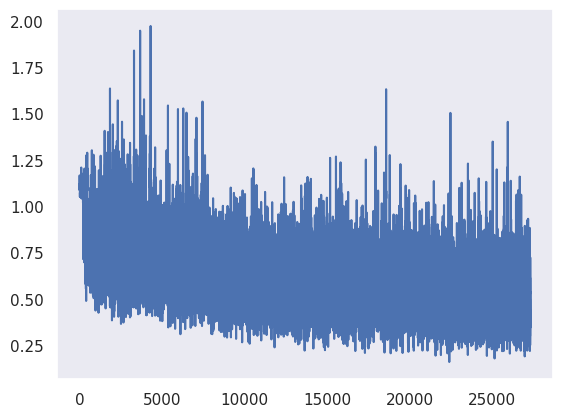

In [60]:
plt.plot(train_losses)

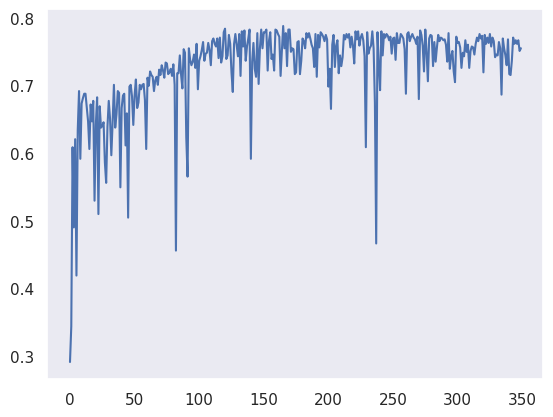

In [61]:
plt.plot(test_accuracy)

In [62]:
best_accuracy

0.7878787878787878

In [63]:
metrics5, confusion_matrix5 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics5.compute())
confusion_matrix5.compute()

Correct: 573/736 (0.7785)
{'acc_detail': tensor([0.9457, 0.5605, 0.8000], device='cuda:0'),
 'acc_unweighted': tensor(0.7688, device='cuda:0'),
 'acc_weighted': tensor(0.7785, device='cuda:0'),
 'f1s': tensor(0.7645, device='cuda:0'),
 'f1s_detail': tensor([0.8793, 0.6234, 0.7907], device='cuda:0'),
 'precision_detail': tensor([0.8215, 0.7022, 0.7816], device='cuda:0'),
 'recall_detail': tensor([0.9457, 0.5605, 0.8000], device='cuda:0'),
 'rocauc': tensor([0.9835, 0.8791, 0.9296], device='cuda:0'),
 'uar': tensor(0.7688, device='cuda:0'),
 'wap': tensor(0.7716, device='cuda:0')}


tensor([[244,  14,   0],
        [ 41, 125,  57],
        [ 12,  39, 204]], device='cuda:0')

In [64]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [65]:
best_epoch = 166
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 596/736 (0.8098)
{'acc_detail': tensor([0.9098, 0.7227, 0.7854], device='cuda:0'),
 'acc_unweighted': tensor(0.8060, device='cuda:0'),
 'acc_weighted': tensor(0.8098, device='cuda:0'),
 'f1s': tensor(0.8058, device='cuda:0'),
 'f1s_detail': tensor([0.9116, 0.7051, 0.8008], device='cuda:0'),
 'precision_detail': tensor([0.9134, 0.6883, 0.8167], device='cuda:0'),
 'recall_detail': tensor([0.9098, 0.7227, 0.7854], device='cuda:0'),
 'rocauc': tensor([0.9836, 0.8851, 0.9298], device='cuda:0'),
 'uar': tensor(0.8060, device='cuda:0'),
 'wap': tensor(0.8118, device='cuda:0')}


tensor([[232,  23,   0],
        [ 15, 159,  46],
        [  7,  49, 205]], device='cuda:0')

In [66]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea